# Wisconsin Breast Cancer [Diagnosis]

## Modules

In [1]:
import numpy as np
import pandas as pd
import os
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score, cohen_kappa_score, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPClassifier
from sklearn import set_config
from neuralsens import partial_derivatives as ns
from joblib import dump

from statsmodels.stats.outliers_influence import variance_inflation_factor

sns.set()
set_config(display='diagram')

d:\ProgramFiles\anaconda3\envs\ml\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
d:\ProgramFiles\anaconda3\envs\ml\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


torch installation could not be found, only numpy activation functions allowed


## Loading data

In [2]:
file_path = os.path.join(os.getcwd(), '../data/breast-cancer.csv')
df = pd.read_csv(file_path)
df.head()

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_worst  \
0  ...         25.38          17.33           184.60      2019.0   
1  ...         24.99          23.41           158.80      1956.0   
2  ...         23.57          25.53           152.50      1709.0   
3  ...         14.91          26.50            98.87       567.7   
4  ...         22.54          16.67           152.20      1575.0   

   smoothness_worst  compactness_worst  concavity_worst  concave points_worst  \
0            0.1622             0.6656           0.7119                0.2654   
1            0.1238             0.1866           0.2416                0.1860   
2            0.1444             0.4245           0.4504                0.2430   
3            0.2098             0.8663           0.6869                0.2575   
4            0.1374             0.2050           0.4000                0.1625   

   symmetry_worst  fractal_dimension_worst  
0          0.4601                  0.11890  
1          0.2750                  0.08902  
2          0.3613                  0.08758  
3          0.6638                  0.17300  
4          0.2364                  0.07678  

[5 rows x 32 columns]

## EDA

In [3]:
print('Null values:', df.isnull().sum().sum())
print('NaN values:', df.isna().sum().sum())
print("Duplicates:", df.duplicated().sum())

Null values: 0
NaN values: 0
Duplicates: 0


Dataset seem to have no missing values, if there were any we would need to understand their origin identify them as MAR, MCAR or MNAR and decide if we want to discard them or retain them.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

Let's use 'id' as index, we could also opt for dropping it uncommenting the first line and commenting the second one

In [5]:
# df.drop(['id'], axis=1, inplace=True) 
df = df.set_index('id')

In [6]:
d = df['diagnosis'].unique()
print("Diagnosis labels:", d)

Diagnosis labels: ['M' 'B']


In [7]:
# We encode target variable as category and encode its label
le = LabelEncoder()
df['diagnosis'] = le.fit_transform(df['diagnosis'].astype('category'))

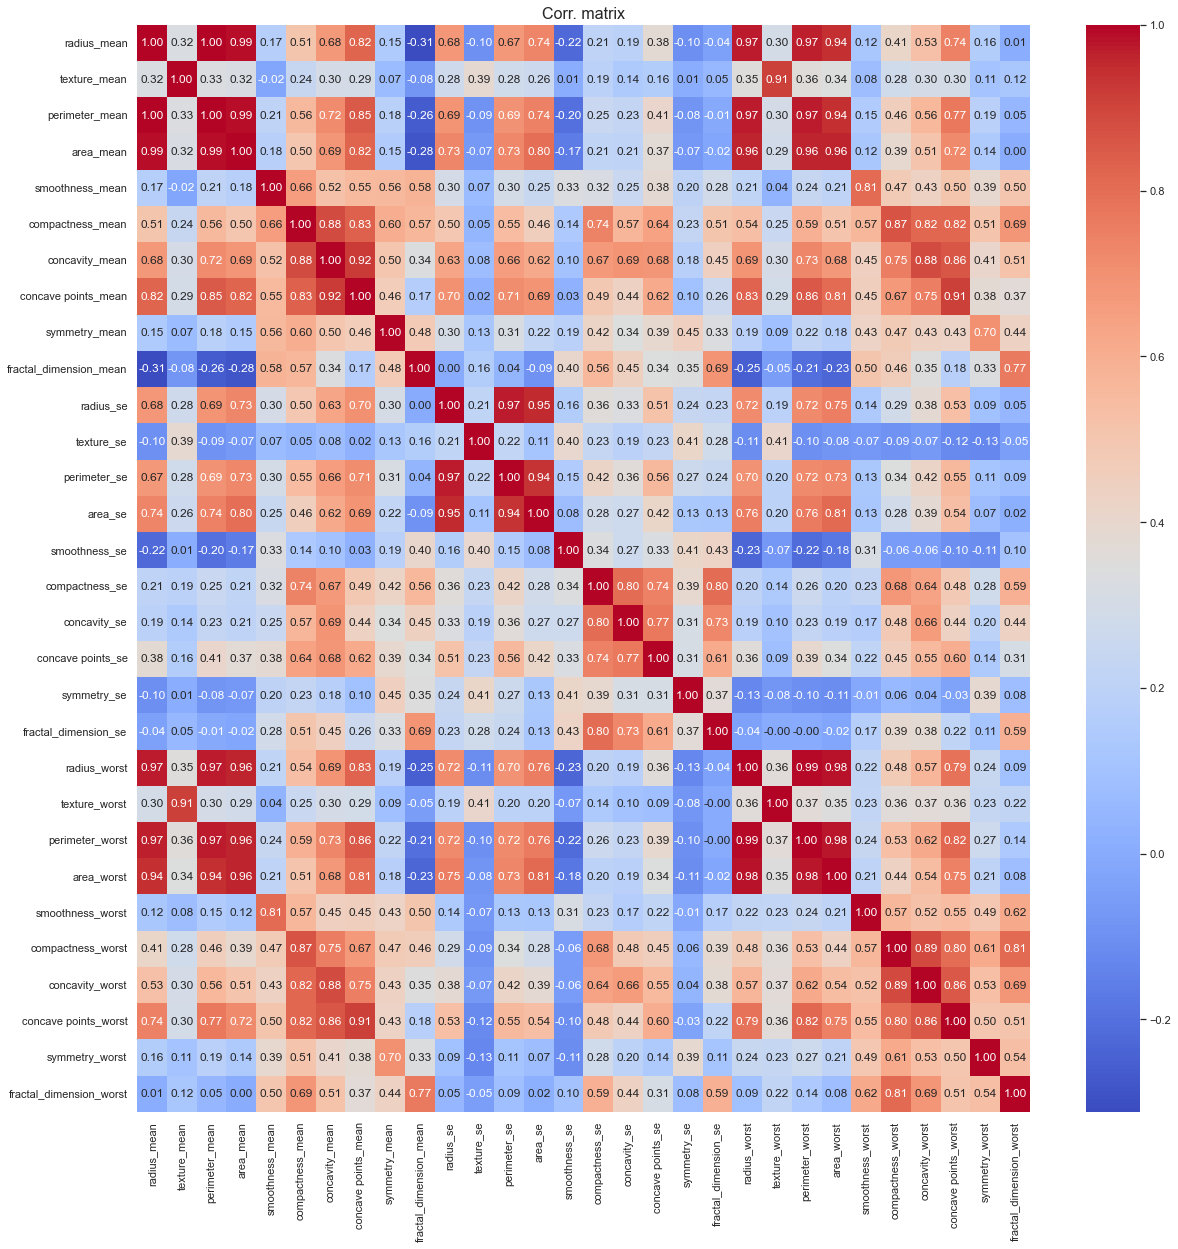

In [16]:
def corrMatrix(df:pd.DataFrame, title:None):
    plt.figure(figsize=(20,20))
    df_corr = df.select_dtypes(include=['int64','float64']).corr()
    sns.heatmap(df_corr, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title(title, fontsize=16)
    plt.show()

# We can see some highly correlated variables, some make sense due to their mathematical formulation or meaning: parameter-radius and area-radius or concave_points-concavity; 
# other might provide some insight: concave_points-radius

corrMatrix(df, 'Corr. matrix')

In [14]:
df.describe().round(2)

diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
count     569.00       569.00        569.00          569.00     569.00   
mean        0.37        14.13         19.29           91.97     654.89   
std         0.48         3.52          4.30           24.30     351.91   
min         0.00         6.98          9.71           43.79     143.50   
25%         0.00        11.70         16.17           75.17     420.30   
50%         0.00        13.37         18.84           86.24     551.10   
75%         1.00        15.78         21.80          104.10     782.70   
max         1.00        28.11         39.28          188.50    2501.00   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count           569.00            569.00          569.00               569.00   
mean              0.10              0.10            0.09                 0.05   
std               0.01              0.05            0.08                 0.04   
min               0.05              0.02            0.00                 0.00   
25%               0.09              0.06            0.03                 0.02   
50%               0.10              0.09            0.06                 0.03   
75%               0.11              0.13            0.13                 0.07   
max               0.16              0.35            0.43                 0.20   

       symmetry_mean  ...  radius_worst  texture_worst  perimeter_worst  \
count         569.00  ...        569.00         569.00           569.00   
mean            0.18  ...         16.27          25.68           107.26   
std             0.03  ...          4.83           6.15            33.60   
min             0.11  ...          7.93          12.02            50.41   
25%             0.16  ...         13.01          21.08            84.11   
50%             0.18  ...         14.97          25.41            97.66   
75%             0.20  ...         18.79          29.72           125.40   
max             0.30  ...         36.04          49.54           251.20   

       area_worst  smoothness_worst  compactness_worst  concavity_worst  \
count      569.00            569.00             569.00           569.00   
mean       880.58              0.13               0.25             0.27   
std        569.36              0.02               0.16             0.21   
min        185.20              0.07               0.03             0.00   
25%        515.30              0.12               0.15             0.11   
50%        686.50              0.13               0.21             0.23   
75%       1084.00              0.15               0.34             0.38   
max       4254.00              0.22               1.06             1.25   

       concave points_worst  symmetry_worst  fractal_dimension_worst  
count                569.00          569.00                   569.00  
mean                   0.11            0.29                     0.08  
std                    0.07            0.06                     0.02  
min                    0.00            0.16                     0.06  
25%                    0.06            0.25                     0.07  
50%                    0.10            0.28                     0.08  
75%                    0.16            0.32                     0.09  
max                    0.29            0.66                     0.21  

[8 rows x 31 columns]

To ease visualization, understand better how each measure contributes to the diagnosis, compare and contrast, we are going to analyze them separately dividing the dataframe in three. Besides since the measures are over the same feature we will reduce multicolinearity and facilitate interpretation

In [9]:
# Separamos cada feature en sus tres medidas
df_mean = df[df.columns[:11]]
df_se = df.drop(df.columns[1:11], axis=1).drop(df.columns[21:], axis=1)
df_worst = df.drop(df.columns[1:21], axis=1)

The dataset is imbalanced, we could consider resampling, it will be discussed at the end of the EDA

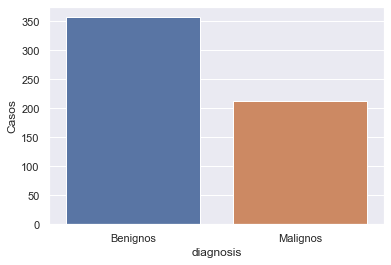

Benign Cases: 357
Malign Cases: 212


In [10]:
# Estamos ante un dataset desbalanceado

ax = sns.countplot(x='diagnosis', data=df)
ax.set_ylabel("Casos")
plt.xticks([0, 1], ['Benignos', 'Malignos']) 
plt.show()

B, M = df['diagnosis'].value_counts()
print('Benign Cases:', B)
print('Malign Cases:', M)

Variables like radius_mean, perimeter_mean, area_mean or concave_points_mean seem to have a strong effect over the output,
others like symmetry_mean or fractal_dimension_mean not as much.

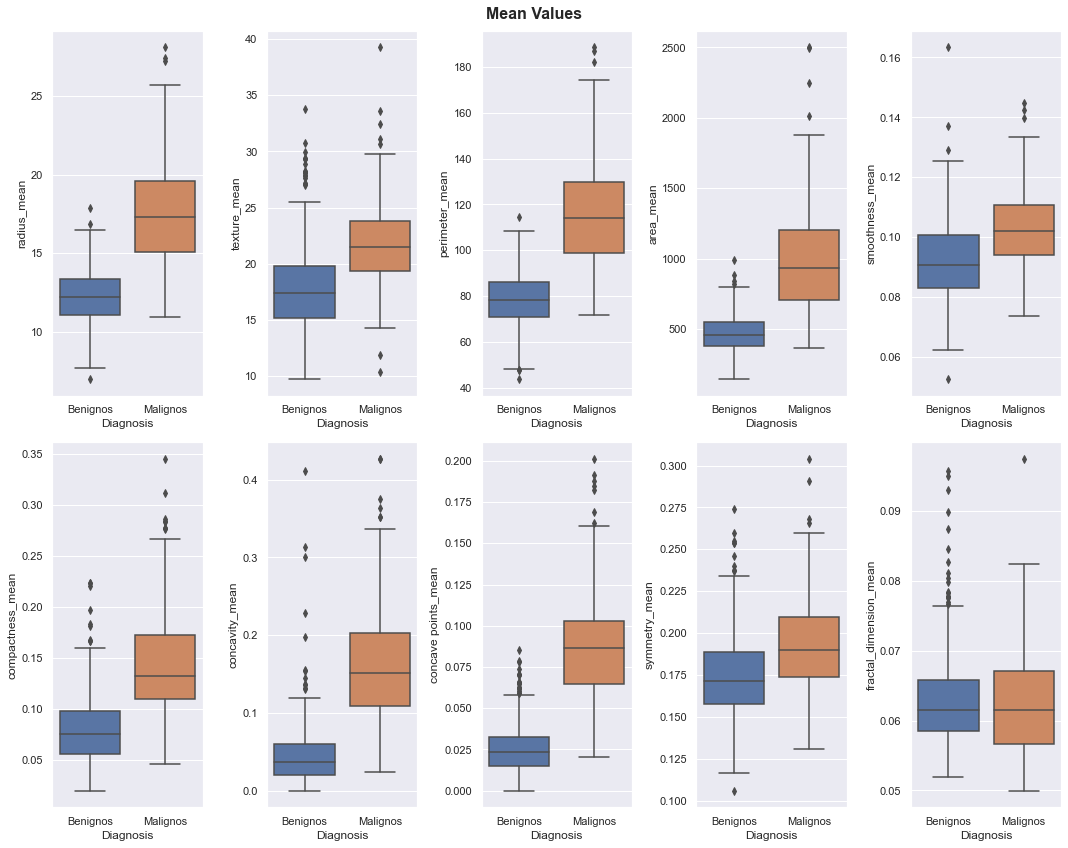

In [11]:
def boxPlot(df:pd.DataFrame, title:str=None, y:str='diagnosis', ncols:int=None, nrows:int=None)->tuple[plt.Figure, np.ndarray]:
    '''
    Print boxplots against target variable, assumes target variable is included in the dataframe.
    Plots by default in a 2x5 grid

    params:
        - df: Dataframe containing the data to plot
        - title: title
        - y: target variable
        - ncols: num cols in plot
        - nrows: num of rows in plot
    '''
    columns = df.columns.tolist()
    columns.remove(y)

    if (ncols is None) and (nrows is None):
        ncols = (len(columns)-1) // 2 +1
        nrows = 2
    elif ncols is None:
        ncols = (len(columns)-1) // nrows + 1
    elif nrows is None:
        nrows = len(columns) // ncols + 1 

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 12))


    for i, col_name in enumerate(columns):
        row = i // ncols 
        col = i % ncols

        ax = axes[row, col]

        sns.boxplot(x='diagnosis', y=col_name, data=df, ax=ax)
        ax.set_xticklabels(['Benignos', 'Malignos']) 
        ax.set_xlabel('Diagnosis')
        ax.set_ylabel(col_name)

    if title:
        fig.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Variables como radius_mean, perimeter_mean, area_mean o concave_points_mean parecen tener un efecto notable sobre la salida
# otras como symmetry_mean o fractal_dimension_mean no tanto a primera vista

boxPlot(df_mean, 'Mean Values')

Variables like radius_se, perimeter_se or area_se seem to have a strong effect over the output,
others like texture_se, smoothness_se or symmetry_se not as much.

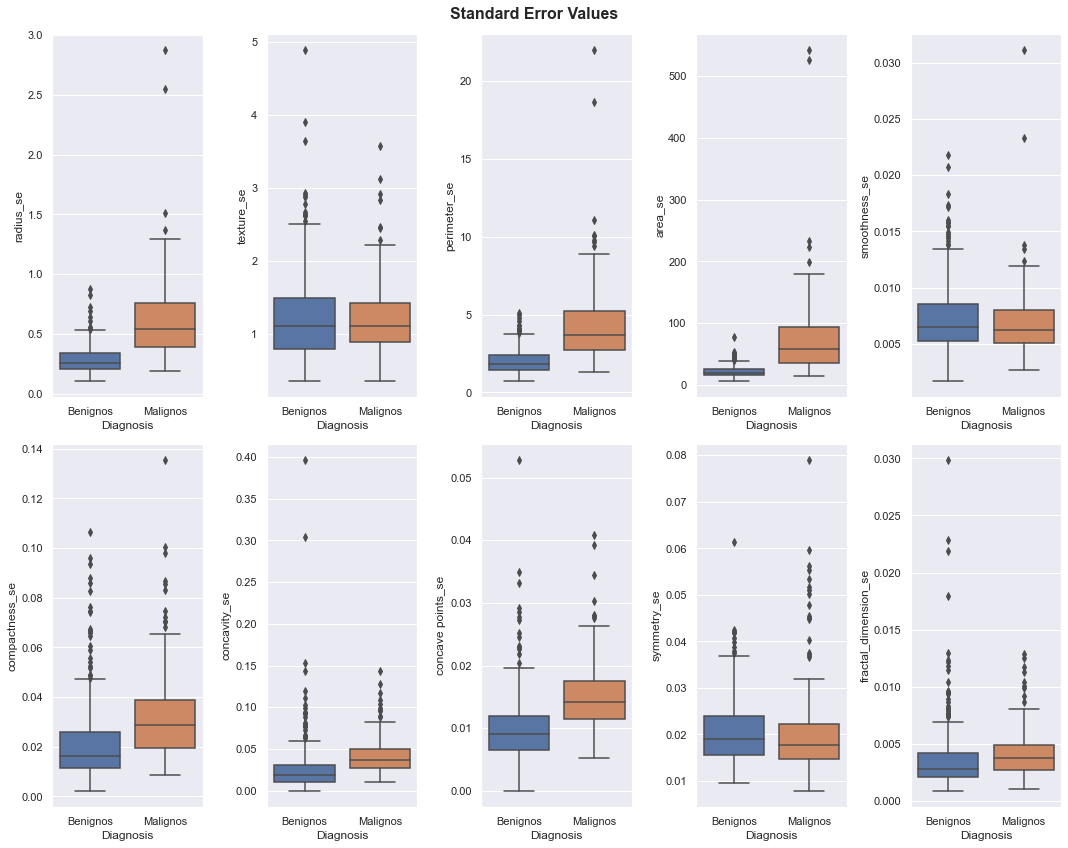

In [12]:
# Variables como radius_se, perimeter_se o area_se parecen tener un efecto notable sobre la salida
# otras como texture_se, smoothness_se o symmetry_se no tanto a primera vista

boxPlot(df_se, 'Standard Error Values')

Variables like radius_worst, perimeter_worst, area_worst or concave_points_worst parecen seem to have a strong effect over the output,
others like symmetry_worst or fractal_dimension_worst not as much.

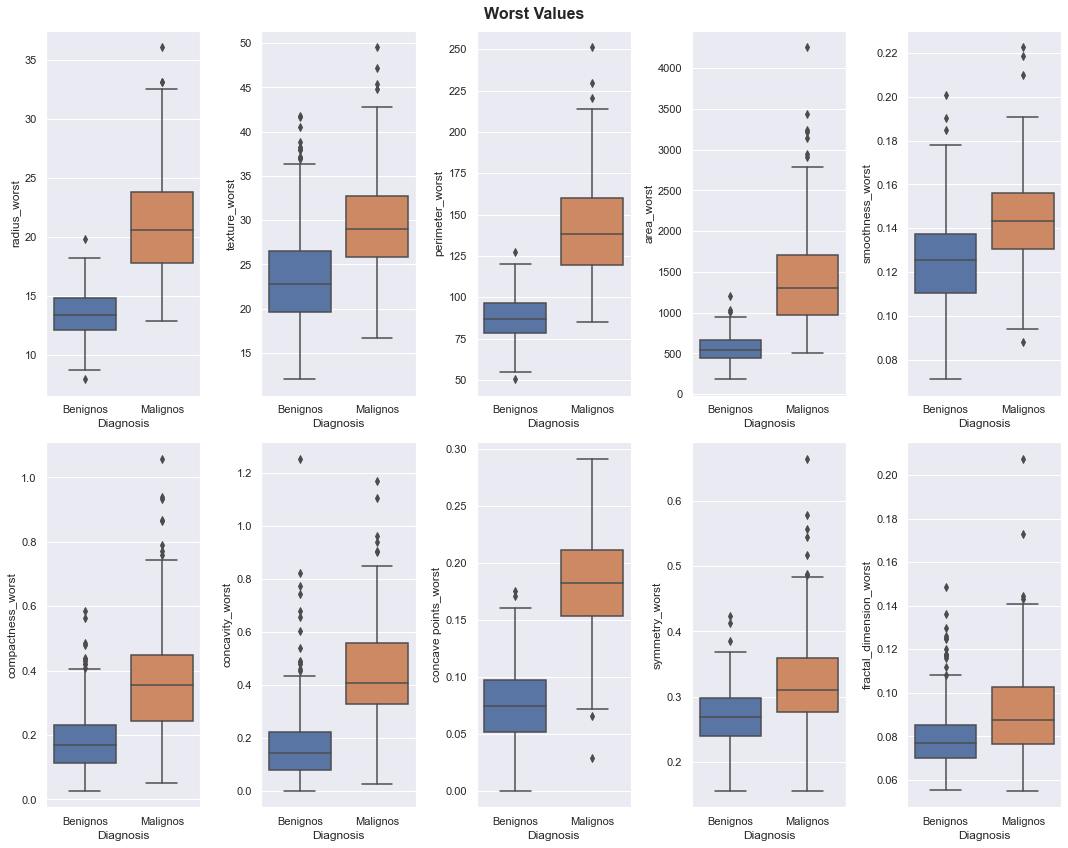

In [13]:
# Variables como radius_mean, perimeter_mean, area_mean o concave_points_mean parecen tener un efecto notable sobre la salida
# otras como symmetry_mean o fractal_dimension_mean no tanto a primera vista

# Podemos observar en esta ultima como en la anteriores la presencia de outliers univariantes
# Mas adelante se barajara su estudio y eliminación
boxPlot(df_worst, 'Worst Values')

We can see some perfectly correlated variables, like: parameter-radius and area-radius which storngly suggest multicolinearity, this can be explained since these three: perimeter, radius and area all contain similat information, the size of the nucleus and are closely related in their mathematical formulation. </br>
Other less but still correlater dariable is concave_points-concavity which makes sense given they treating the same concept; 
Other correlation to be taken into account ~0.8: concave_points-radius

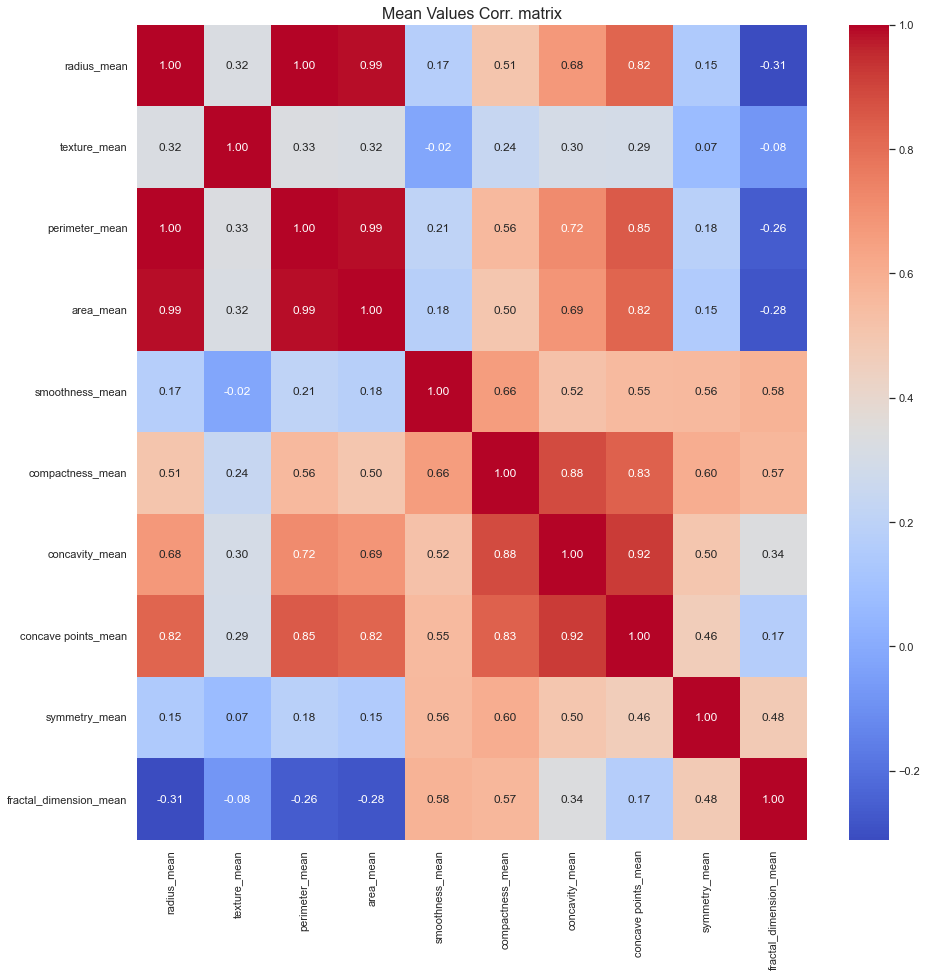

In [14]:
def corrMatrix(df:pd.DataFrame, title:None):
    plt.figure(figsize=(15,15))
    df_corr = df.select_dtypes(include=['int64','float64']).corr()
    sns.heatmap(df_corr, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title(title, fontsize=16)
    plt.show()

# We can see some highly correlated variables, some make sense due to their mathematical formulation or meaning: parameter-radius and area-radius or concave_points-concavity; 
# other might provide some insight: concave_points-radius

corrMatrix(df_mean, 'Mean Values Corr. matrix')

Same reasoning as before for the above mentioned, the interesting correlation here comes from: compactness-concavity and compactness-fractal_dimension

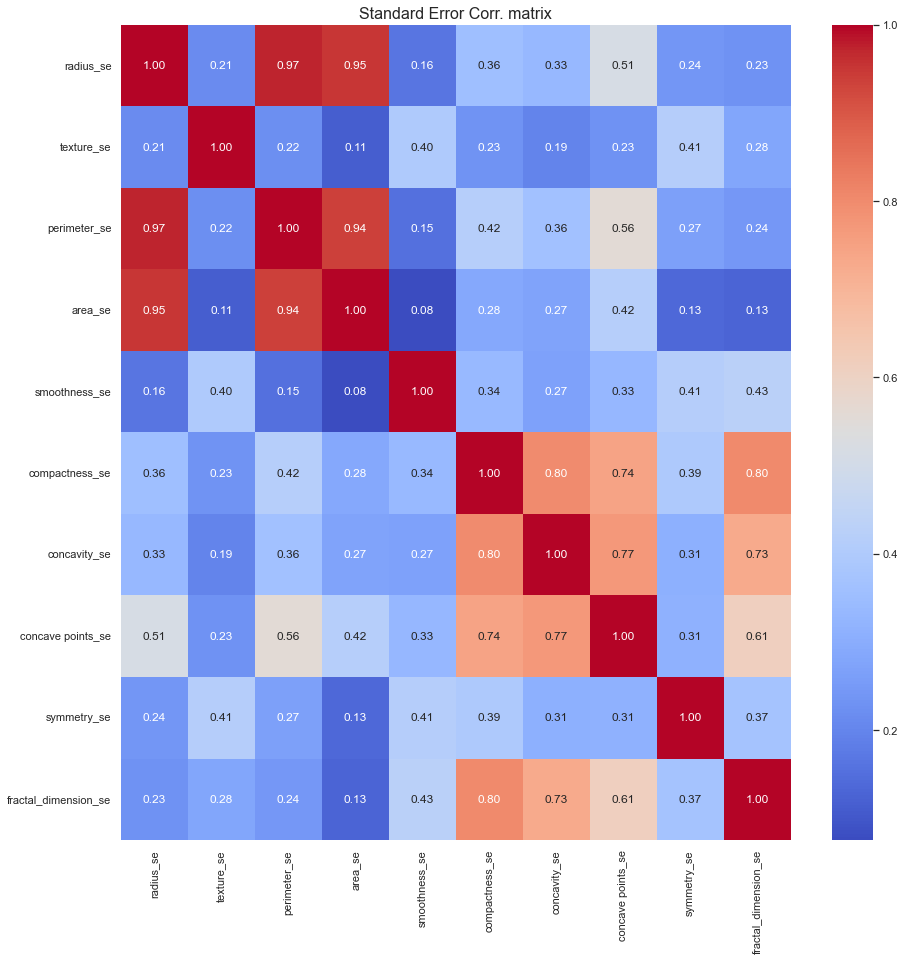

In [15]:
# Same reasoning as before for the above mentioned, the interesting correlation here comes from: compactness-concavity and compactness-fractal_dimension
corrMatrix(df_se, 'Standard Error Corr. matrix')

Same reasoning as before for the above mentioned, we can highlight concave_points-radius/area/compactness/concavity and compactness-fractal

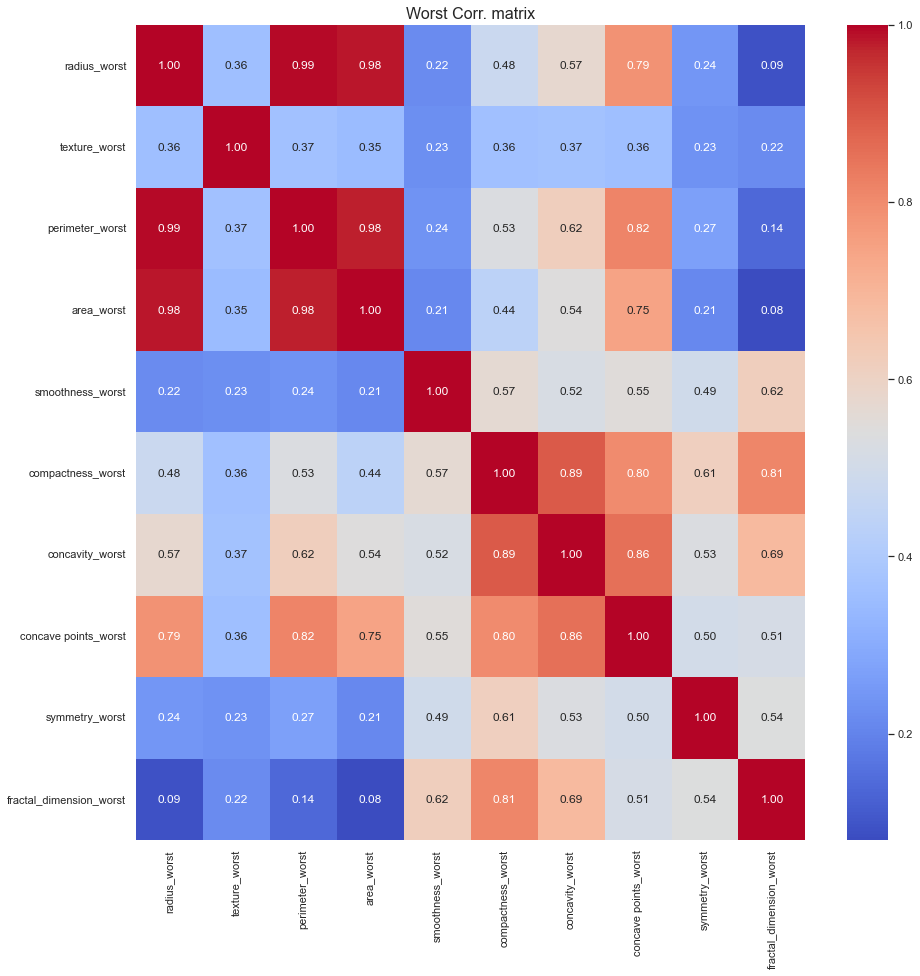

In [16]:
# Same reasoning as before for the above mentioned, we can highlight concave_points-radius/area/compactness/concavity and compactness-fractal
corrMatrix(df_worst, 'Worst Corr. matrix')

- frac_dimension_mean has almost no correlation with target variable, all other seem significant</br>
- texture_se, smoothness_se, symmetry_se and fractal_dimension_se have almost no correlation</br>
- All seem correlated</br>

This in combination with the multicolinearity assumptions suggest that we might want to perform dimensionality reduction and work with a new uncorrelated subset of variables

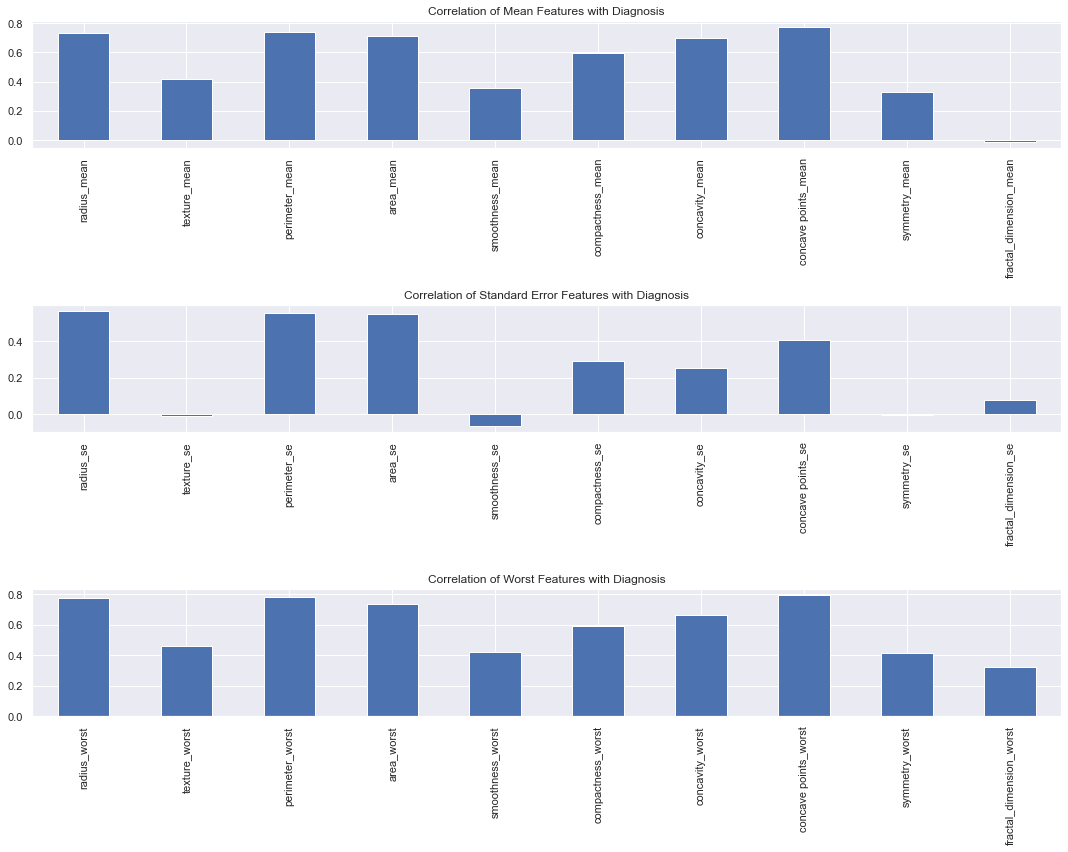

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 12))

# frac_dimension_mean has almost no correlation with target variable,
# all other seem significant
ax1 = axes[0]
df_mean.drop('diagnosis', axis=1).corrwith(df_mean.diagnosis).plot(kind='bar', grid=True, title="Correlation of Mean Features with Diagnosis", ax=ax1)

# texture_se, smoothness_se, symmetry_se and fractal_dimension_se have almost no correlation
ax2 = axes[1]
df_se.drop('diagnosis', axis=1).corrwith(df_se.diagnosis).plot(kind='bar', grid=True, title="Correlation of Standard Error Features with Diagnosis", ax=ax2)

# All seem correlated
ax3 = axes[2]
df_worst.drop('diagnosis', axis=1).corrwith(df_worst.diagnosis).plot(kind='bar', grid=True, title="Correlation of Worst Features with Diagnosis", ax=ax3)

plt.tight_layout()
plt.show()


We can observe almost perfecly linear patterns in some of the features, specifically in the three we mentioned before, which seems to veify our multicolinearity assumption but we will ascertain it more with a last test further below. Moving forward as we discussed we will use dimensionality reduction and given the linearity of the variables we will attempt PCA. </br>
We can also observe what could look like multivariate outliers in plots like perimeter_se-texture_se, we will take a closer look to some of these later although most can be observed in the pairplots. </br>
A few features like area_mean and fractal_dimension_mean seem negatively correlated </br>

Text(0.5, 0.98, 'Mean features pairplot')

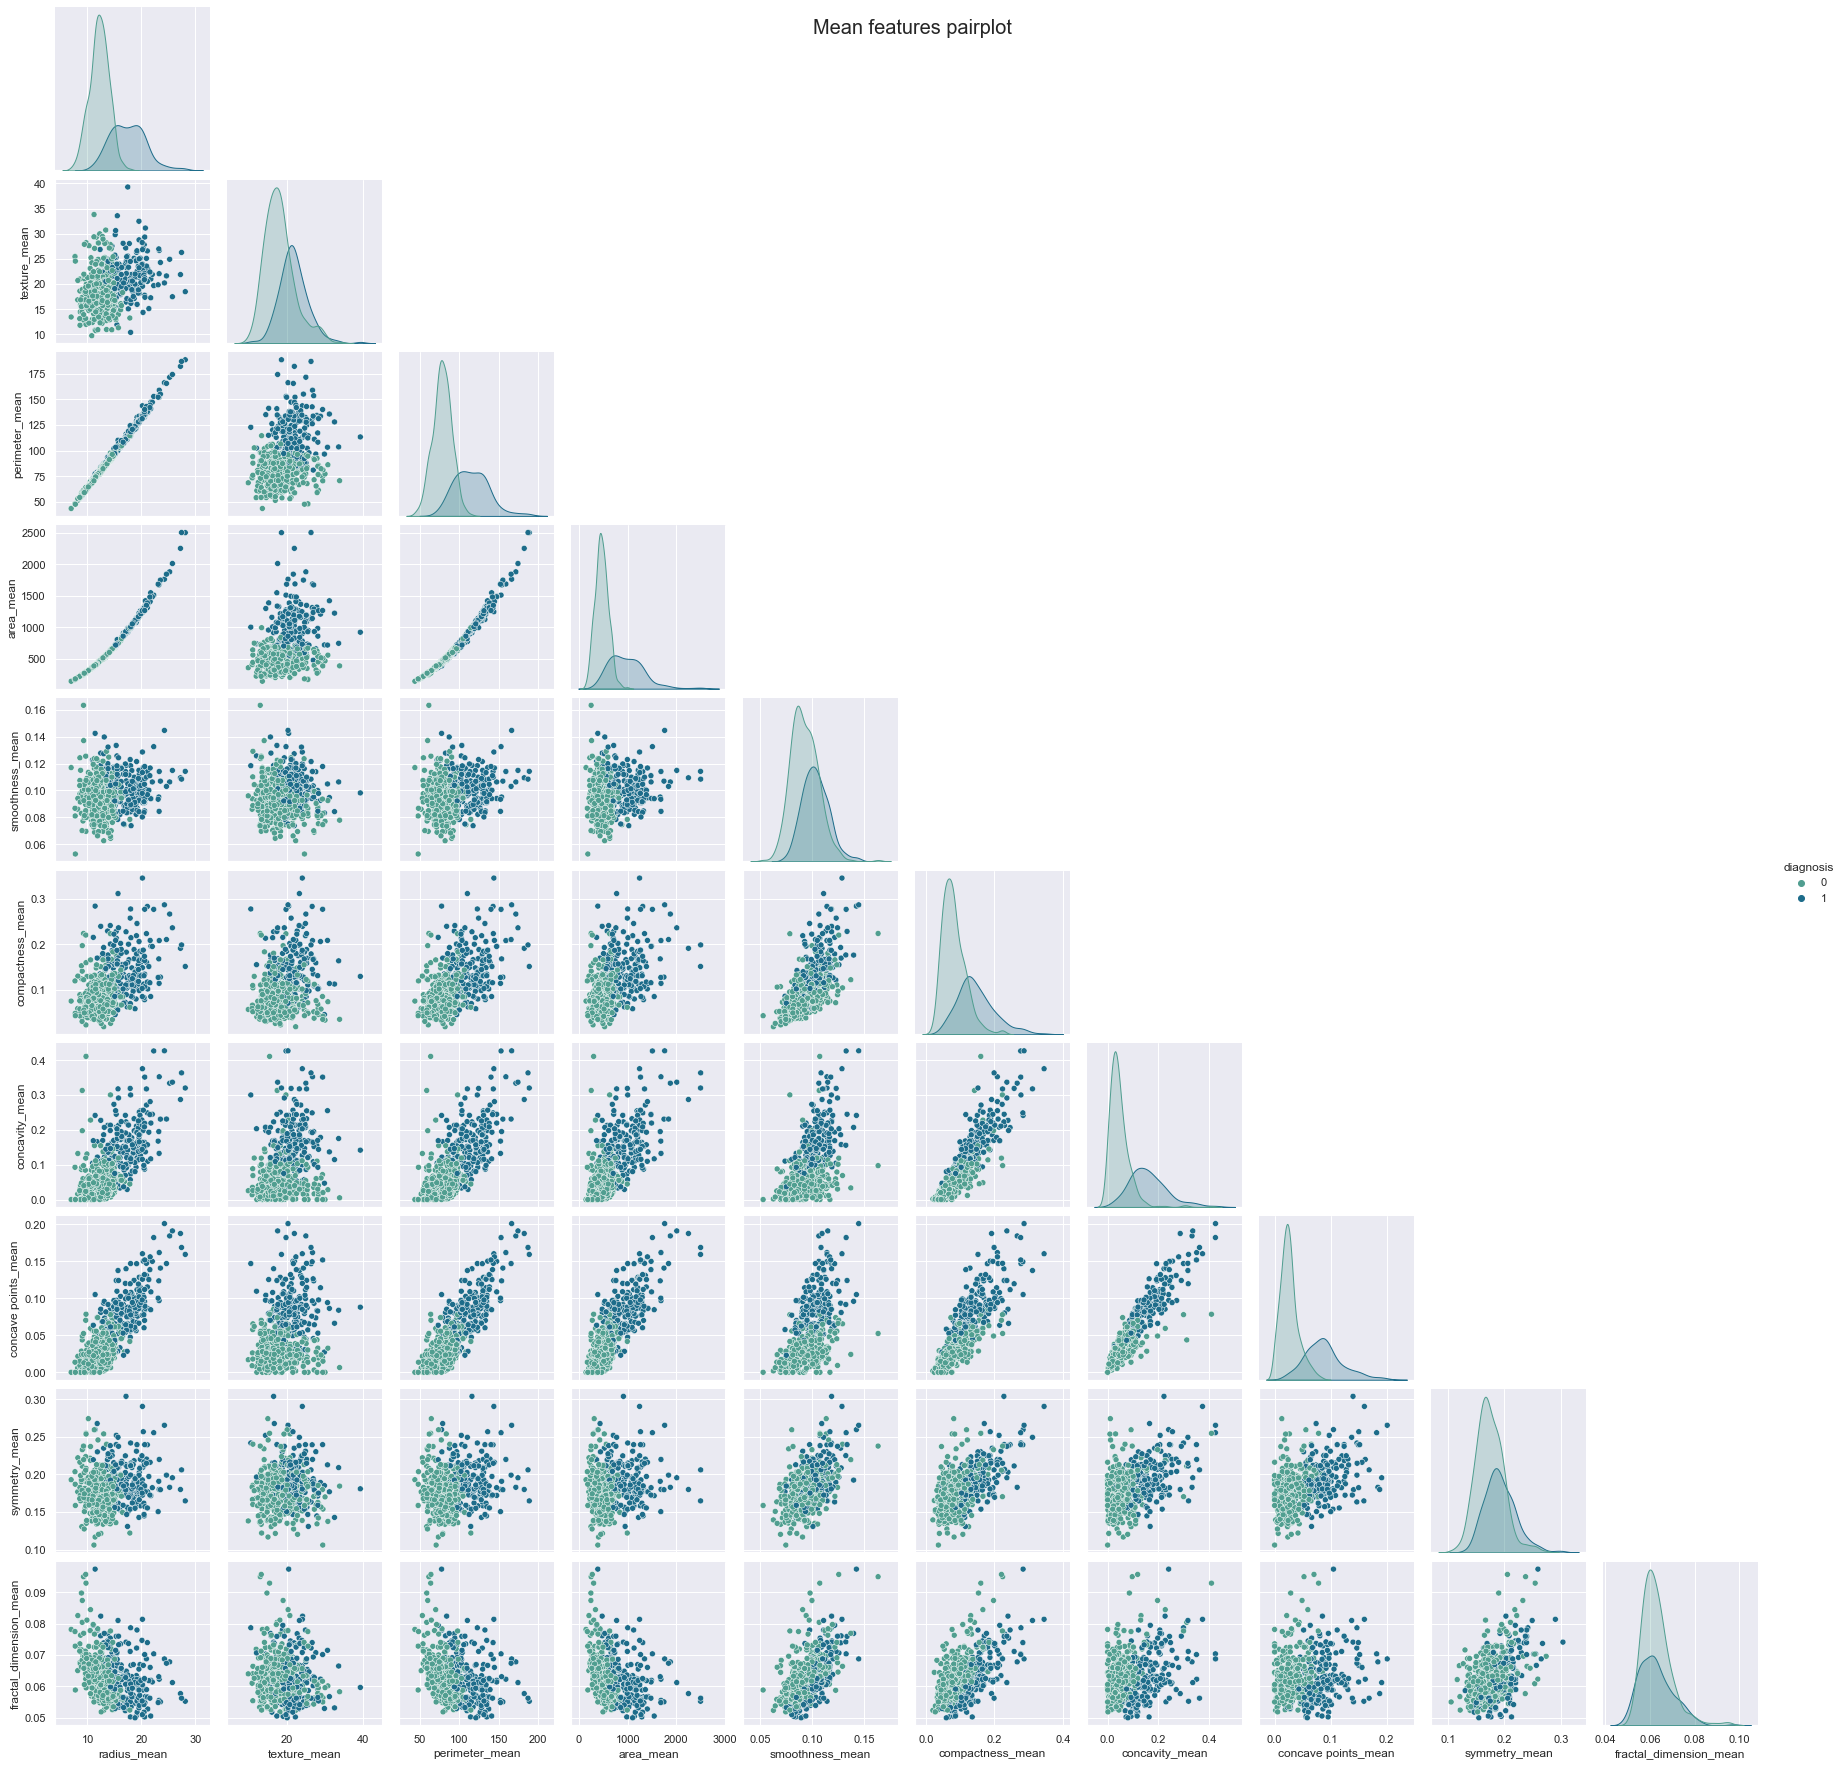

In [18]:
sns.pairplot(data=df_mean, hue='diagnosis', palette='crest', corner=True).fig.suptitle('Mean features pairplot', fontsize = 20)

Text(0.5, 0.98, 'Standard Error features pairplot')

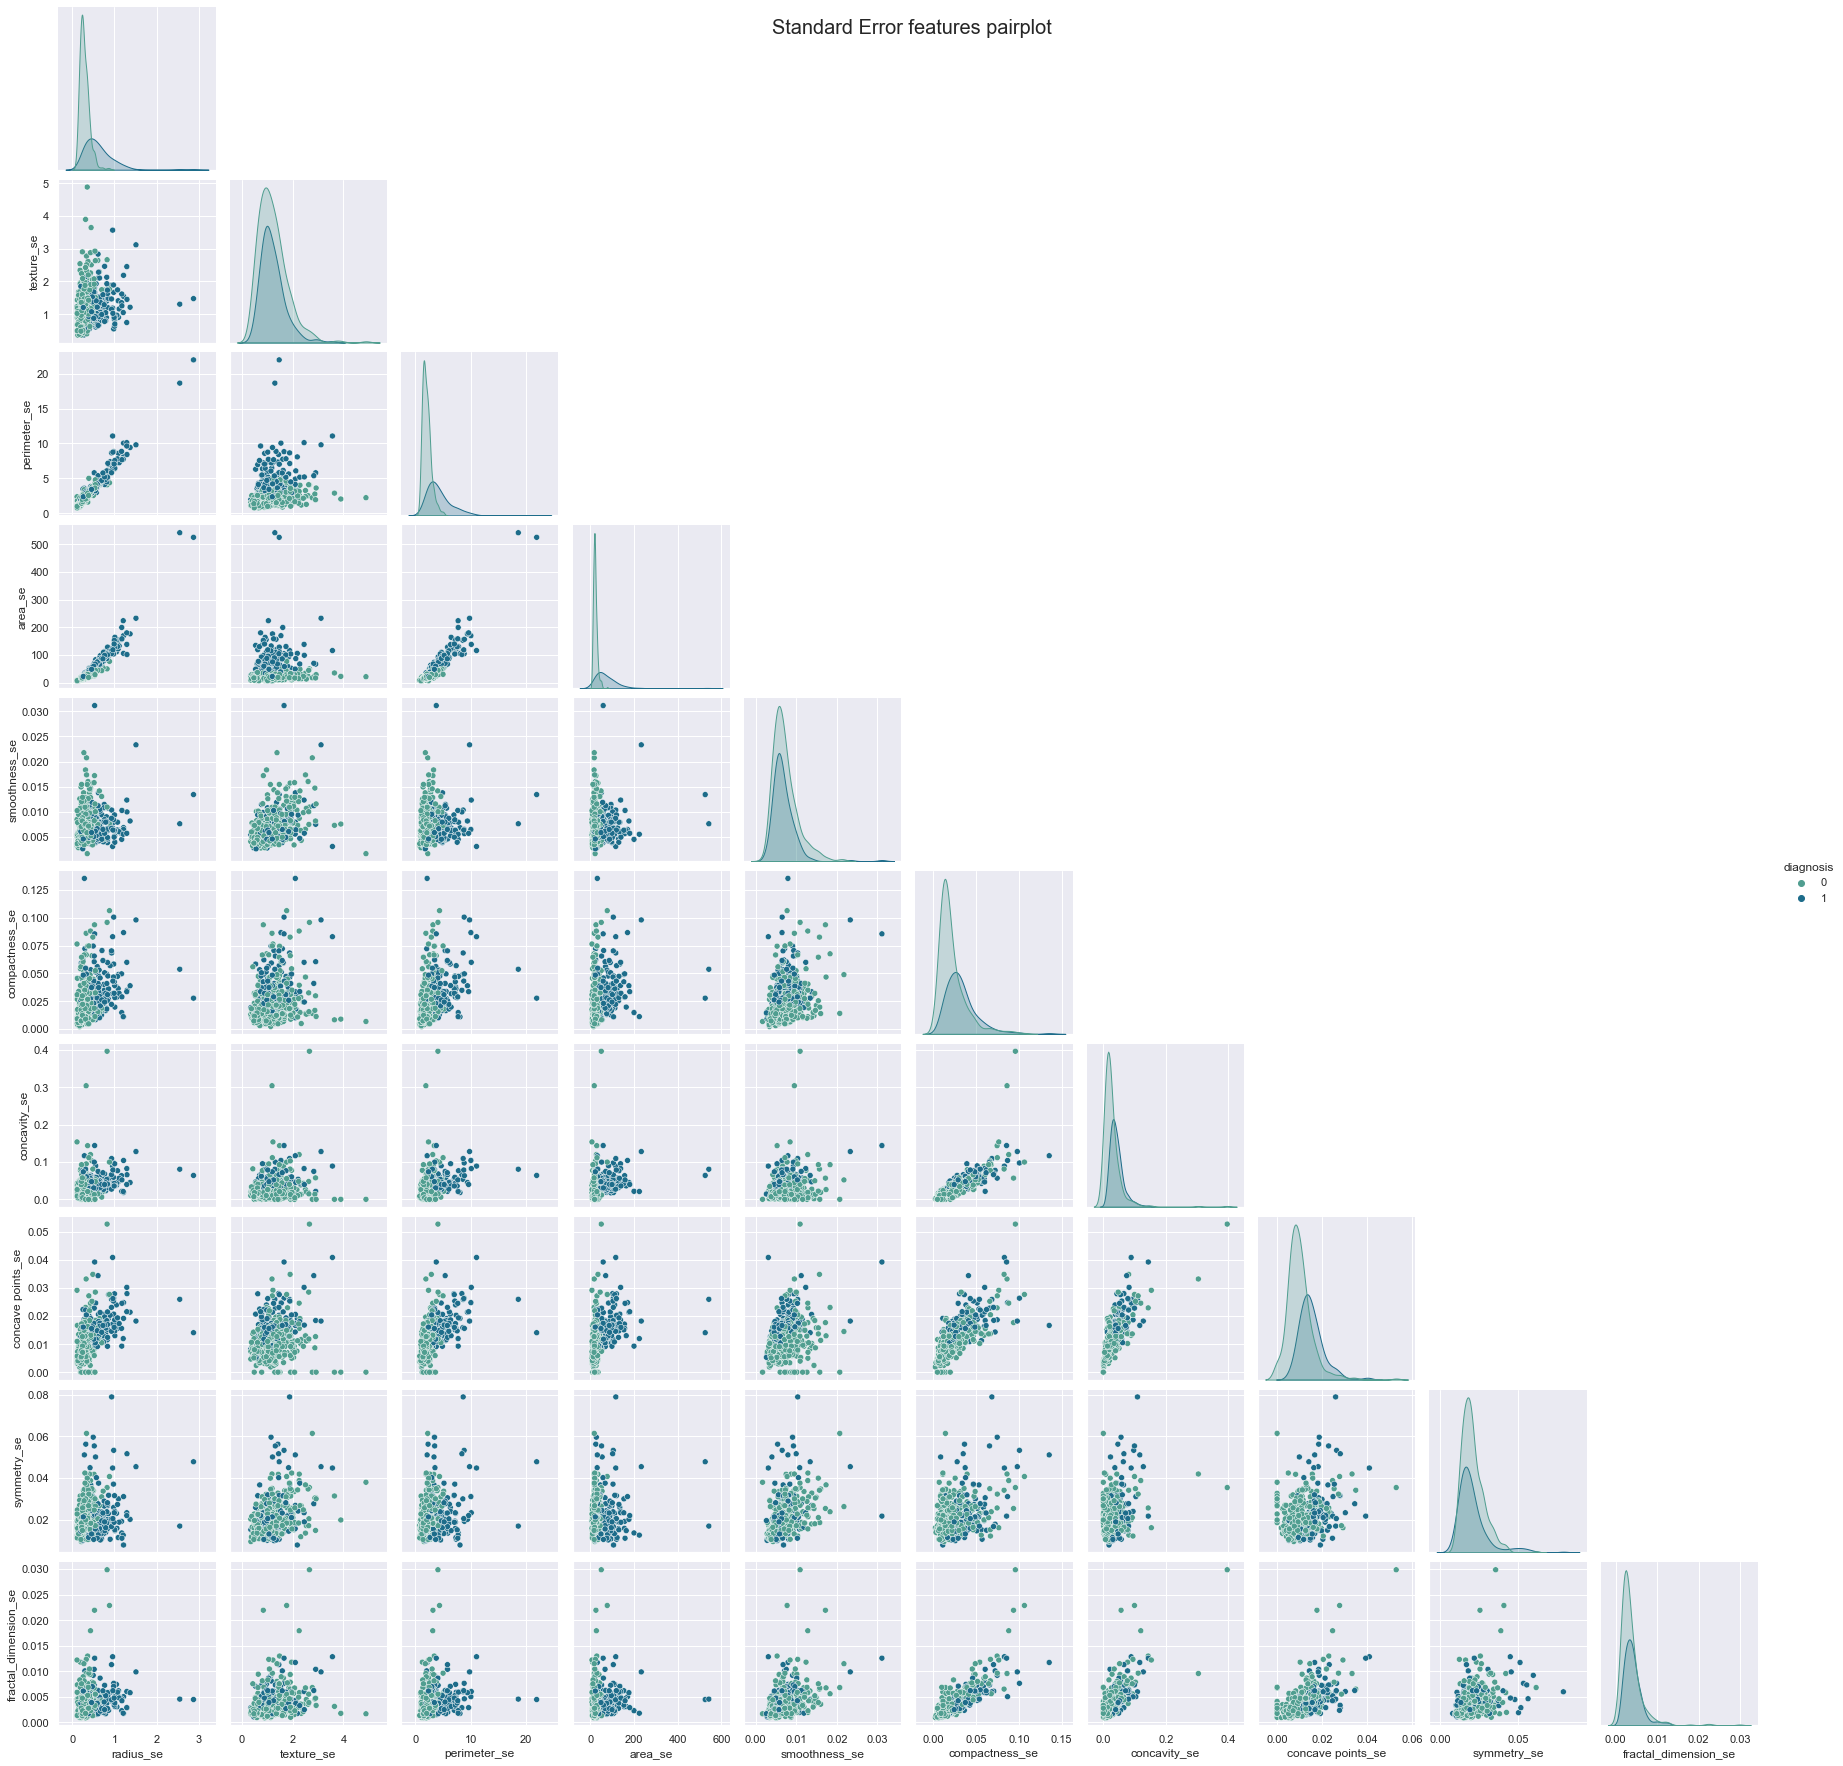

In [19]:
sns.pairplot(data=df_se, hue='diagnosis', palette='crest', corner=True).fig.suptitle('Standard Error features pairplot', fontsize = 20)

Text(0.5, 0.98, 'Worst features pairplot')

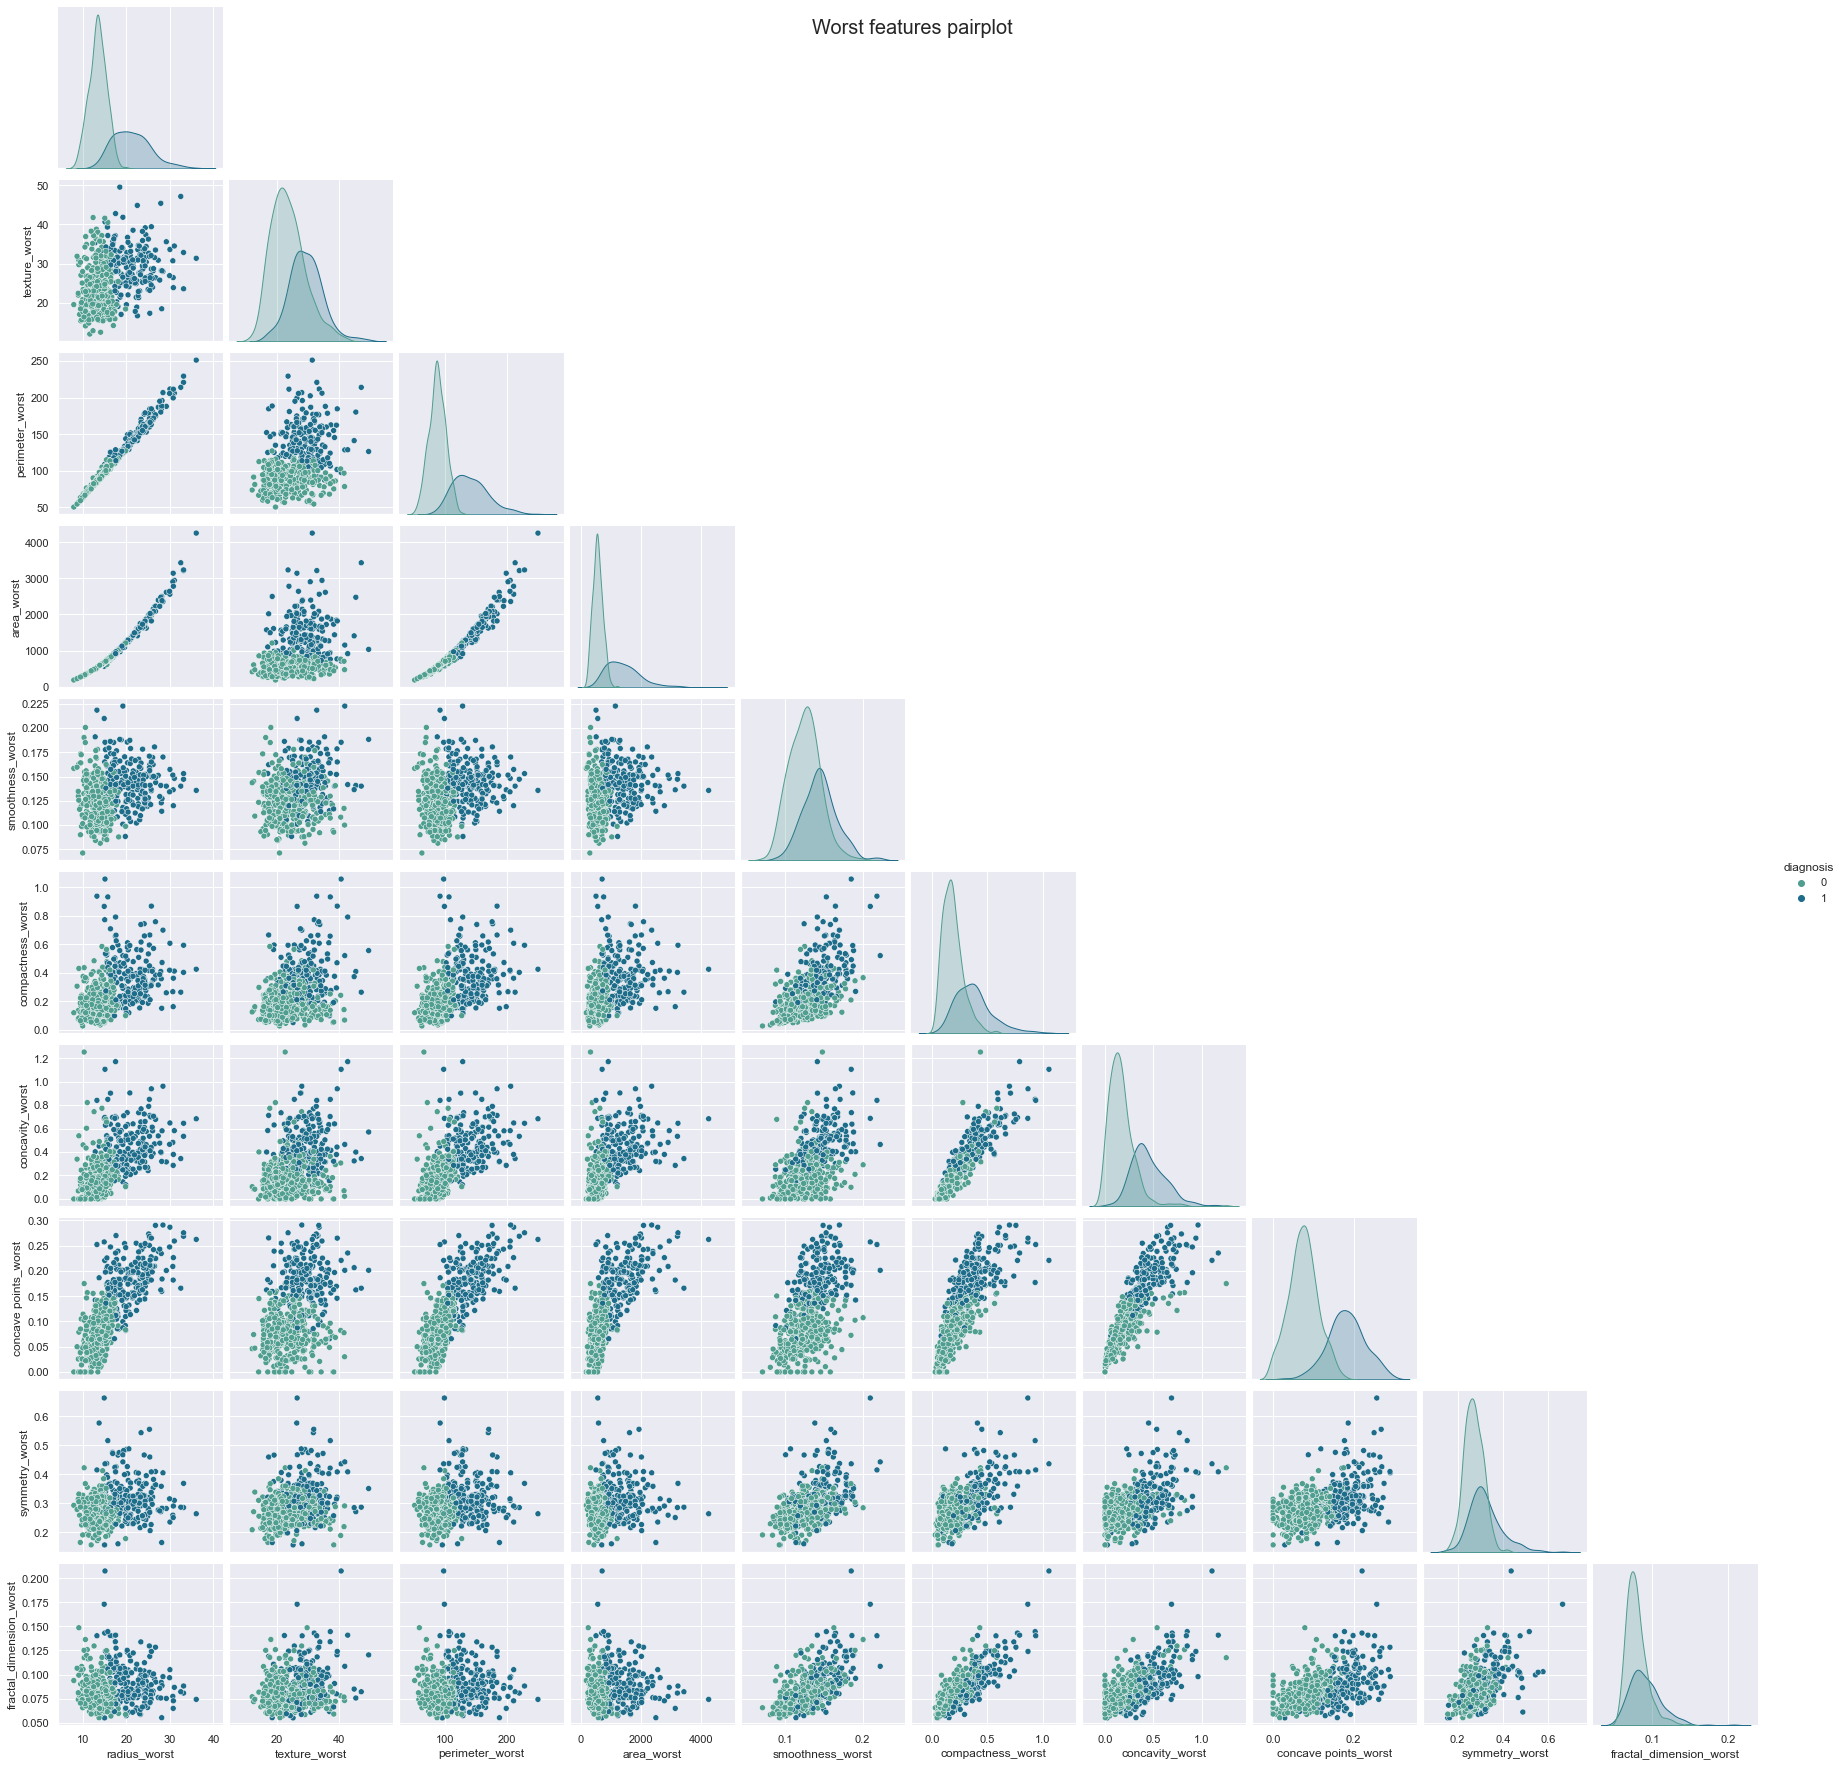

In [20]:
sns.pairplot(data=df_worst, hue='diagnosis', palette='crest', corner=True).fig.suptitle('Worst features pairplot', fontsize = 20)

As we thought, we can see in the Variance Inflation Factor that these features that showed vey high correlation among themselves and were almost perfectly linear (radius, perimeter, area) show muticolinearity. Given these characteristics and to reduce our variables we are gonna apply PCA.

In [21]:
def calculateVIF(df:pd.DataFrame):
    df = df.select_dtypes(include=['int64','float64']) 

    df['intercept'] = 1

    vif = pd.DataFrame()
    vif['VIF Factor'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif['features'] = df.columns

    print(vif.round(1), '\n')

calculateVIF(df_mean)
calculateVIF(df_se)
calculateVIF(df_worst)

    VIF Factor                features
0       1606.8             radius_mean
1          1.2            texture_mean
2       1956.1          perimeter_mean
3         56.3               area_mean
4          3.0         smoothness_mean
5         22.6        compactness_mean
6         11.7          concavity_mean
7         21.7     concave points_mean
8          1.8           symmetry_mean
9          6.5  fractal_dimension_mean
10      1306.2               intercept 

    VIF Factor              features
0         28.4             radius_se
1          1.4            texture_se
2         25.8          perimeter_se
3         15.0               area_se
4          1.5         smoothness_se
5          5.1        compactness_se
6          4.0          concavity_se
7          3.8     concave points_se
8          1.5           symmetry_se
9          3.6  fractal_dimension_se
10        12.0             intercept 

    VIF Factor                 features
0        137.2             radius_worst
1   

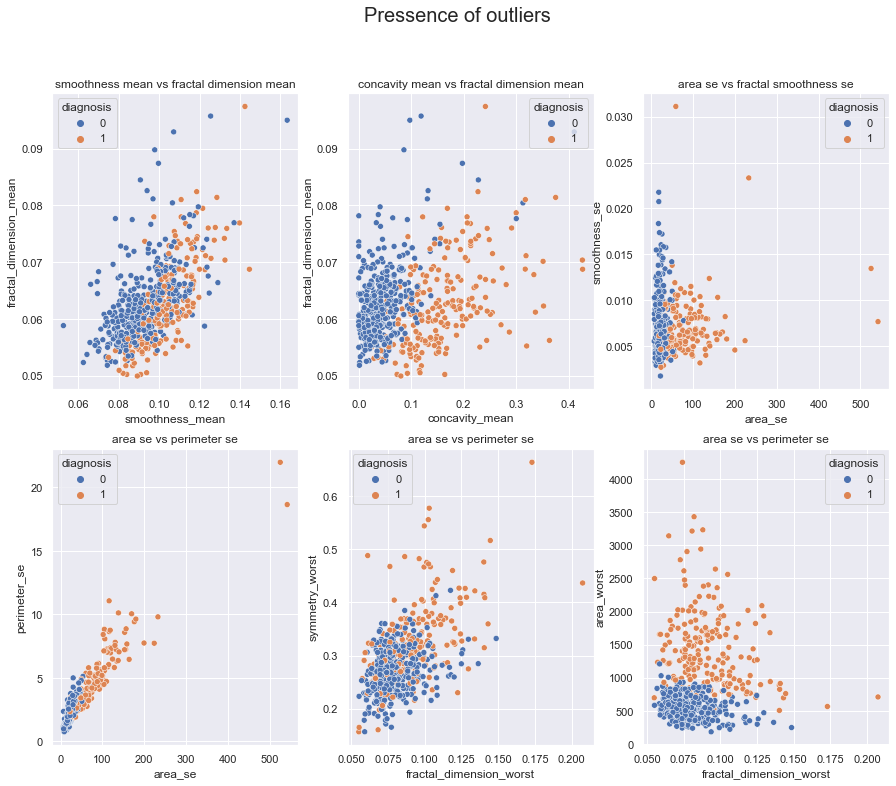

In [22]:
fig = plt.figure(figsize=(15,12))

plt.subplot(231)
ax1 = sns.scatterplot(x = df_mean['smoothness_mean'], y = df_mean['fractal_dimension_mean'], hue = "diagnosis", data = df_mean)
plt.title('smoothness mean vs fractal dimension mean')

plt.subplot(232)
ax2 = sns.scatterplot(x = df_mean['concavity_mean'], y = df_mean['fractal_dimension_mean'], hue = "diagnosis", data = df_mean)
plt.title('concavity mean vs fractal dimension mean')

plt.subplot(233)
ax2 = sns.scatterplot(x = df_se['area_se'], y = df_se['smoothness_se'], hue = "diagnosis",data = df_se)
plt.title('area se vs fractal smoothness se')

plt.subplot(234)
ax2 = sns.scatterplot(x = df_se['area_se'], y = df_se['perimeter_se'], hue = "diagnosis",data = df_se)
plt.title('area se vs perimeter se')

plt.subplot(235)
ax2 = sns.scatterplot(x = df_worst['fractal_dimension_worst'], y = df_worst['symmetry_worst'], hue = "diagnosis",data = df_worst)
plt.title('area se vs perimeter se')

plt.subplot(236)
ax2 = sns.scatterplot(x = df_worst['fractal_dimension_worst'], y = df_worst['area_worst'], hue = "diagnosis",data = df_worst)
plt.title('area se vs perimeter se')

fig.suptitle('Pressence of outliers', fontsize = 20)
plt.show()

Looking at the cumulative explained variance a reasonable amount of PC to choose is 7 with which we will have 91% of variance explained or 10 to go a bit deeper and get 95%

In [23]:
# Preprocessing the values to perform PCA
numeric_features = df.select_dtypes(include=['int64','float64']).columns.values.tolist()
scaler = StandardScaler()
X_transformed = scaler.fit_transform(X=df[numeric_features])

In [24]:
pca = PCA(n_components=X_transformed.shape[1],)
X_pca = pca.fit_transform(X_transformed)

In [25]:
exp_variance = pd.DataFrame(data=pca.explained_variance_ratio_, index = ['PC' + str(n_pca + 1) for n_pca in range(pca.n_components)], columns=['Exp_variance'])
exp_variance['cum_Exp_variance'] = exp_variance['Exp_variance'].cumsum()
exp_variance

Exp_variance  cum_Exp_variance
PC1       0.442720          0.442720
PC2       0.189712          0.632432
PC3       0.093932          0.726364
PC4       0.066021          0.792385
PC5       0.054958          0.847343
PC6       0.040245          0.887588
PC7       0.022507          0.910095
PC8       0.015887          0.925983
PC9       0.013896          0.939879
PC10      0.011690          0.951569
PC11      0.009797          0.961366
PC12      0.008705          0.970071
PC13      0.008045          0.978117
PC14      0.005234          0.983350
PC15      0.003138          0.986488
PC16      0.002662          0.989150
PC17      0.001980          0.991130
PC18      0.001754          0.992884
PC19      0.001649          0.994533
PC20      0.001039          0.995572
PC21      0.000999          0.996571
PC22      0.000915          0.997486
PC23      0.000811          0.998297
PC24      0.000602          0.998899
PC25      0.000516          0.999415
PC26      0.000273          0.999688
PC27      0.000230          0.999918
PC28      0.000053          0.999971
PC29      0.000025          0.999996
PC30      0.000004          1.000000

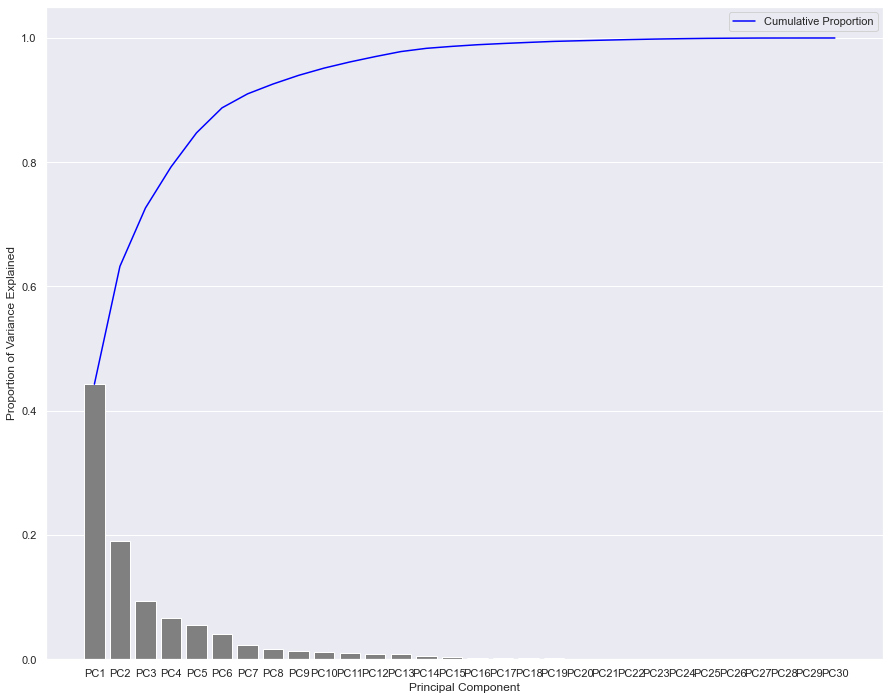

In [26]:
fig = plt.figure(figsize=(15,12))
sns.barplot(data=exp_variance, x=exp_variance.index, y='Exp_variance', color='gray')
sns.lineplot(data=exp_variance, x=exp_variance.index, y='cum_Exp_variance', color='blue', label='Cumulative Proportion')
plt.gca().set_ylabel('Proportion of Variance Explained')
plt.gca().set_xlabel('Principal Component')
plt.legend()
plt.show()

If we analyze the first three PC:
- PC1 seems to be a size variable with all loadings positive
- PC2 has positive loadings in variables that are not radius, area, texture y perimeter and negative loadings in those. It seems to be a measure of the shape characteristics of the nuclei but inversely related to the size.
- PC3 has for all standard error measures positive loadings, while wost measures have negative loadings (except for radius, area, texture and perimeter). PC3 seems to reflect the variability in shape measures penalizing worst measures and giving a positive effect to standard errors.

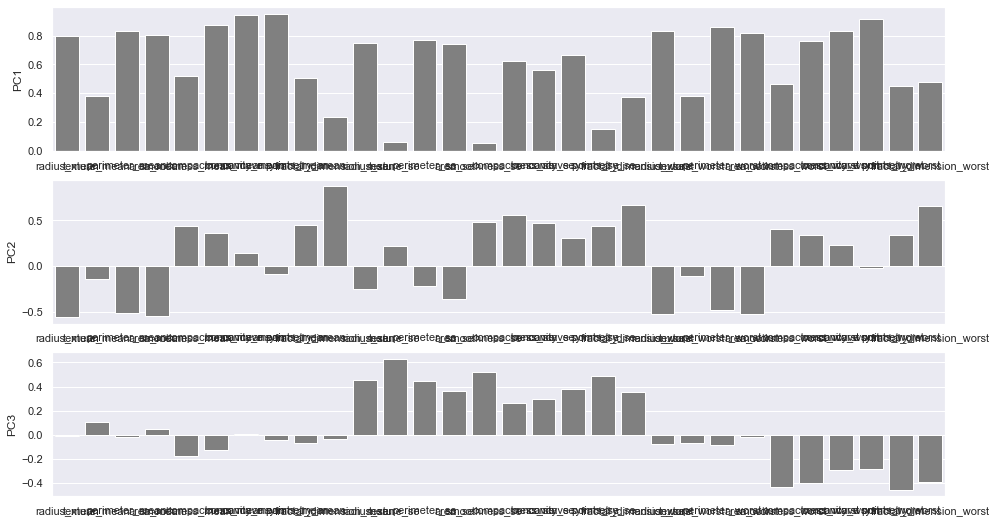

In [27]:
loadings = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_), columns=['PC' + str(pca + 1) for pca in range(pca.n_components)], index=numeric_features)

fig, axes = plt.subplots(3, 1, figsize=(16,9))
PC = 0
for ax in axes.ravel():
    sns.barplot(data=loadings, x=loadings.index, y=loadings.columns.values.tolist()[PC], color='gray', ax=ax)
    PC += 1

## Training

Since we are dealing with human lives here, we are going to have two scenarios:

1.- In this first one, we are going to assume that diagnosing a patient's cell as malign when they ae benign carries severe consequences in the patient's life, albeit because of the implications of the following treatment. For this case we are going to want to be right all the time we diagnose a patient with malign cells, for that a sound metric for success to use would be Precision.

2.- In this second one, we are going to assume that once we classify a cell as malign, further medical test will be carried out to verify that is the case. With that assumption in mind our worst case scenario will be missclassifying a malign cell such causing the release of a potetentially ill person. Given this reasoning I belive a sound metric for success to use is Recall. 

Given these two scenarios and with the idea in mind of having to choose one model only, we are going to opt for f1-score as our metric to try and maximize both scenarios.

Below we are going to define some helper functions:

In [28]:
def display_metrics(true_labels, predicted_labels, positive_label, negative_label, model):
    # Calculate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=[positive_label, negative_label])

    # Calculate various metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels, pos_label=positive_label)
    precision = precision_score(true_labels, predicted_labels, pos_label=positive_label)
    balanced_accuracy = balanced_accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels, pos_label=positive_label)

    # Display confusion matrix
    plt.figure(figsize=(15,12))
    ConfusionMatrixDisplay(cm, display_labels=[positive_label, negative_label]).plot(values_format='.0f')
    plt.show()

    # Print metrics
    print(f'Accuracy: {accuracy:.6f}')
    print(f'Precision: {precision:.6f}')
    print(f'Recall: {recall:.6f}')
    print(f'Balanced Accuracy: {balanced_accuracy:.6f}')
    print(f'F1 Score: {f1:.6f}')

    return {'model': [model],
            'acc': [accuracy],
            'prec': [precision],
            'recall': [recall],
            'bal_acc': [balanced_accuracy],
            'f1': [f1]}

In [29]:
def metricsPlots(y_test, y_pred, y_proba):
    # CALIBRATION PLOT
    y_prob = y_proba[:, 1]  # Probabilities for the positive outcome
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_prob, n_bins=10)

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=1, ncols=5, figsize=(22, 6))

    ax1.plot(mean_predicted_value, fraction_of_positives, 's-')
    ax1.plot([0, 1], [0, 1], '--', color='gray')
    ax1.set_xlabel('Mean predicted value')
    ax1.set_ylabel('Fraction of positives')
    ax1.set_title('Calibration Plot')

    # ROC CURVE
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)

    ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax2.set_xlim([-0.05, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('Receiver Operating Characteristic')
    ax2.legend(loc="lower right")


    # RECALL CUTOFF CURVE
    cutoffs = np.linspace(0.01, 0.99, 100)
    recall_scores = []

    for cutoff in cutoffs:
        y_pred = (y_prob > cutoff).astype(int)
        recall_scores.append(recall_score(y_test, y_pred))

    ax3.plot(cutoffs, recall_scores, 'o-')
    ax3.set_xlabel('Cutoff')
    ax3.set_ylabel('Recall')
    ax3.set_title('Recall vs. Cutoff')

    # HISTOGRAM PROB PLOT
    prob_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Probability': y_prob})

    prob_df_yes = prob_df[prob_df['Actual'] == 1]
    prob_df_yes_right = prob_df_yes[prob_df_yes['Actual'] == prob_df_yes['Predicted']]
    prob_df_yes_wrong = prob_df_yes[prob_df_yes['Actual'] != prob_df_yes['Predicted']]


    sns.histplot(prob_df_yes_right['Probability'], ax=ax4, kde=False, bins=10, label='M Right', color='red')
    ax4.set_title('Probability Distribution of class M when right')
    ax4.legend()

    sns.histplot(prob_df_yes_wrong['Probability'], ax=ax5, kde=False, bins=10, label='M Missed', color='blue')
    ax5.set_title('Probability Distribution of class M when wrong')
    ax5.legend()
    
    plt.tight_layout()
    plt.show()

In [30]:
def plotLearning(estimator, title, X, y, ylim = None, cv = None,
                        n_jobs = 1, train_sizes = np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv = cv, n_jobs = n_jobs, train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha = 0.1, color = "g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color = "r",
             label = "Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color = "g",
             label = "Cross-validation score")
    plt.legend(loc = "best")
    plt.show()

In [31]:
def model_selection(param, pipe, scoring, model_name, cv=5, learning=True):
    model_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                             param_grid=param, # Defined grid to search in
                             n_jobs=-1, # Number of cores to use (parallelize)
                             scoring=scoring, # https://scikit-learn.org/stable/modules/model_evaluation.html
                             cv=5) # Number of Folds 

    #Train Model
    model_fit.fit(X_train, y_train)

    print(f"{model_name} Trained")
    print('Best params:\n', model_fit.best_params_)

    if learning:
        plotLearning(model_fit, model_name, X=X_train, y=y_train, cv=cv)

    y_pred_tr = model_fit.predict(X_train)
    y_prob_tr = model_fit.predict_proba(X_train)
    y_pred_ts = model_fit.predict(X_test)
    y_prob_ts = model_fit.predict_proba(X_test)

    return model_fit, y_pred_tr, y_prob_tr, y_pred_ts, y_prob_ts

### Resampling

Given that the imbalance is not too exaggerated and to avoid the risk of ovefitting the model we are going to put off resampling with a technique like ROSE and just apply stratification when splitting the data.

### Split data

In [32]:
# Train test split: lets do a baseline model with all variables
INPUTS = df.columns.tolist()
OUTPUT = 'diagnosis'
INPUTS.remove(OUTPUT)
X = df[INPUTS]
y = df[OUTPUT]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)  # Stratify to keep class proportion in both train and test

# Create dataset to store models metrics
all_results = pd.DataFrame()

### Baseline Model

As we can see our baseline model, a simple logistic regression model using the whole dataset without further preprocessing besides standarizing or fine-tuning provides what seem like very good test results:

- Recall: 0.9524 
- Balanced Accuracy: 0.9692
- Precision: 0.9756
- F1 Score: 0.9638
- Almost perfect AUC

However, lets try and see if we can maximize these results specifically the recall, as we ee in the CV score was a bit lower, and the model still misses some malign cases even with a lot of confidence in its mistake in some case (probabilitie of 1 and 0.8) applying what we have learned in the EDA and some fine tuning, and lets aim to understand the underlying reasons behind the predictions.

In [60]:
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_LR = INPUTS

#ModLogReg = LogisticRegression()
LogReg_fit = Pipeline(steps=[('scaler',StandardScaler()), # Preprocess the variables when training the model 
                        ('LogReg',LogisticRegression(random_state=42))]) # Model to use in the pipeline

#Train model
LogReg_fit.fit(X_train, y_train);

print("Logistic Regression Trained")

Logistic Regression Trained


In [61]:
y_pred_tr = LogReg_fit.predict(X_train)
y_prob_tr = LogReg_fit.predict_proba(X_train)
y_pred_ts = LogReg_fit.predict(X_test)
y_prob_ts = LogReg_fit.predict_proba(X_test)

<Figure size 1080x864 with 0 Axes>

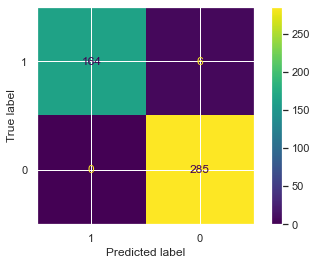

Accuracy: 0.986813
Precision: 1.000000
Recall: 0.964706
Balanced Accuracy: 0.982353
F1 Score: 0.982036


In [62]:
lr_train_metrics = display_metrics(y_train, y_pred_tr, 1, 0, 'baseline')

<Figure size 1080x864 with 0 Axes>

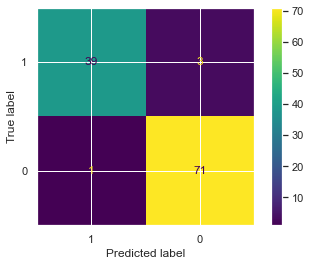

Accuracy: 0.964912
Precision: 0.975000
Recall: 0.928571
Balanced Accuracy: 0.957341
F1 Score: 0.951220


In [63]:
lr_test_metrics = display_metrics(y_test, y_pred_ts, 1, 0, 'baseline')

In [64]:
# Obtain Cross-Validation score
print("Training F1 score is:", cross_val_score(LogReg_fit, X_train, y_train, cv=10, scoring='f1').mean())
print("Training recall is:", cross_val_score(LogReg_fit, X_train, y_train, cv=10, scoring='recall').mean())
print("Training precision is:", cross_val_score(LogReg_fit, X_train, y_train, cv=10, scoring='precision').mean())

Training F1 score is: 0.9576148582600196
Training recall is: 0.9529411764705882
Training precision is: 0.9666666666666668


In [65]:
results = pd.DataFrame(data=lr_test_metrics).set_index('model')
all_results.drop(['baseline'], inplace=True, errors='ignore')
all_results = pd.concat([all_results, results])
all_results

acc   prec    recall   bal_acc       f1
model                                                 
baseline  0.964912  0.975  0.928571  0.957341  0.95122

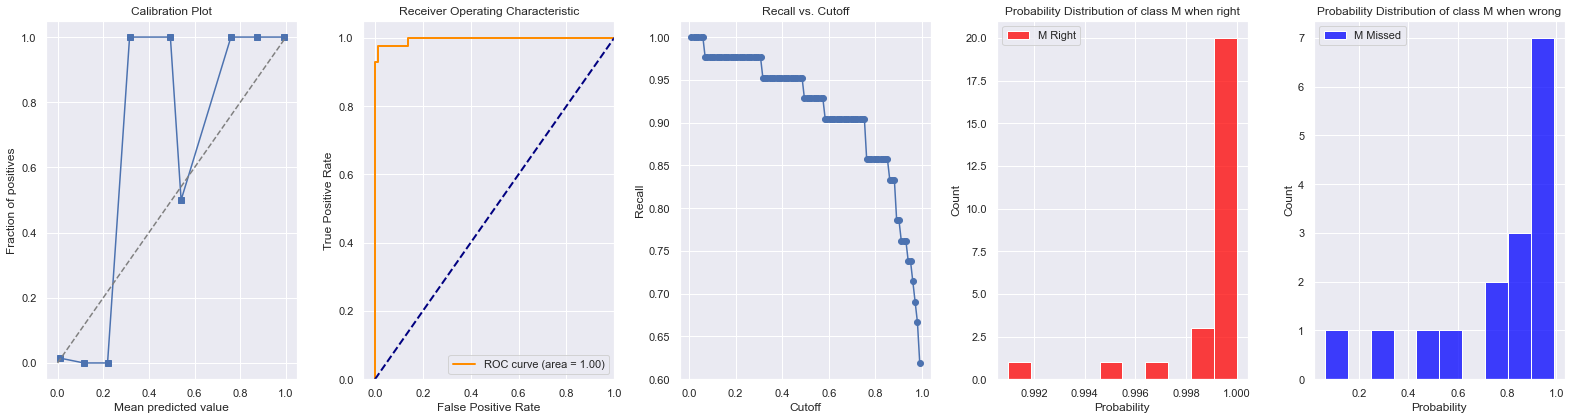

In [66]:
metricsPlots(y_test, y_pred_ts, y_prob_ts)

In [67]:
from scipy.stats import norm, binom_test
import math

# Summary for Logistic Regression model from scikit
def summaryLogReg(modelpipe, X: pd.core.frame.DataFrame, y: pd.core.series.Series):
    """Summary of scikit 'LogisticRegression' models.
    
    Provide feature information of linear regression models,
    such as coefficient, standard error and p-value. It is adapted
    to stand-alone and Pipeline scikit models.
    
    Important restriction of the function is that LogisticRegression 
    must be the last step of the Pipeline.
    Args:
        model: LogisticRegression or Pipeline model
        X (pd.core.frame.DataFrame): Input variables dataframe
        y (pd.core.series.Series): Output variable series
    """
    # Select model from pipeline
        # Obtain coefficients of the model
    if type(modelpipe) is not LogisticRegression:
        model = modelpipe[len(modelpipe) - 1]  
        prep = modelpipe[len(modelpipe) - 2] 
        # Obtain names of the inputs
        try:
            coefnames = [x.split("__")[1] for x in  list(prep.get_feature_names_out())]
        except:
            coefnames = list(prep.get_feature_names_out())
    else:
        model = modelpipe  
        prep = []
        # Obtain names of the inputs
        coefnames = [column for column in X.columns]
    
    # Obtain coefficients of the model
    coefs = model.coef_[0]
    intercept = model.intercept_
    if not intercept == 0:
        coefs = np.append(intercept,coefs)
        coefnames.insert(0,'Intercept')
    # Calculate matrix of predicted class probabilities.
    # Check resLogit.classes_ to make sure that sklearn ordered your classes as expected
    predProbs = modelpipe.predict_proba(X)
    y_pred = predProbs[:,1]
    y_int = y#.cat.codes.to_numpy()
    res = y_int - y_pred
    print('Deviance Residuals:')
    quantiles = np.quantile(res, [0,0.25,0.5,0.75,1], axis=0)
    quantiles = pd.DataFrame(quantiles, index=['Min','1Q','Median','3Q','Max'])
    print(quantiles.transpose())
    # Print coefficients of the model
    print('\nCoefficients:')
    coefs = pd.DataFrame(data=coefs, index=coefnames, columns=['Estimate'])
    ## Calculate std error of inputs ------------- 
    #scale if necessary and build Xdesign
    if prep:
        X_trainMOD = prep.fit_transform(X)
    else:
        X_trainMOD = X
    
    if not intercept == 0:
        X_design = np.hstack([np.ones((X.shape[0], 1)), X_trainMOD])
    else:
        X_design = X_trainMOD
    # Initiate matrix of 0's, fill diagonal with each predicted observation's variance
    V = np.diagflat(np.product(predProbs, axis=1))
    # Covariance matrix
    covLogit = np.linalg.inv(X_design.T @ V @ X_design)
    print(coefs)
    # Std errors
    coefs['Std. Err'] = np.sqrt(np.diag(covLogit))
    # t-value
    coefs['t-value'] = coefs['Estimate'] / coefs['Std. Err']
    # P-values
    coefs['Pr(>|t|)'] = (1 - norm.cdf(abs(coefs['t-value']))) * 2
    coefs['Signif'] = coefs['Pr(>|t|)'].apply(lambda x: '***' if x < 0.001 else ('**' if x < 0.01 else ('*' if x < 0.05 else ('.' if x < 0.1 else ' '))))
    print(coefs)
    print('---\nSignif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1')
    ## AIC criterion ----------------
    # Obtain rank of the model
    rank = len(coefs)
    likelihood = y_pred * y_int + (1 - y_pred) * (1 - y_int)
    AIC = 2*rank - 2*math.log(likelihood.max())
    #print('AIC:',AIC,' (no es fiable, revisar formula de AIC)')
    return

In [68]:
summaryLogReg(LogReg_fit,X_train, y_train)

Deviance Residuals:
        Min       1Q    Median        3Q       Max
0 -0.478524 -0.00469 -0.000123  0.000004  0.989365

Coefficients:
                         Estimate
Intercept               -0.241252
radius_mean              0.359025
texture_mean             0.485609
perimeter_mean           0.351865
area_mean                0.441642
smoothness_mean          0.347900
compactness_mean        -0.441220
concavity_mean           0.779010
concave points_mean      0.948610
symmetry_mean           -0.164186
fractal_dimension_mean  -0.080266
radius_se                1.237079
texture_se              -0.408740
perimeter_se             0.750503
area_se                  0.913437
smoothness_se            0.246711
compactness_se          -0.907620
concavity_se            -0.095406
concave points_se        0.486715
symmetry_se             -0.332383
fractal_dimension_se    -0.591392
radius_worst             0.895402
texture_worst            1.429023
perimeter_worst          0.722600
area_worst   

In [49]:
lr = LogReg_fit.named_steps['LogReg']
print("Classes: ", lr.classes_)
coefficients = pd.DataFrame(lr.coef_, columns=X_train.columns.tolist())
coefficients['intercept'] = lr.intercept_
print("Intercept: ", lr.intercept_)
coefficients

Classes:  [0 1]
Intercept:  [-0.24125152]


radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0     0.359025      0.485609        0.351865   0.441642           0.3479   

   compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
0          -0.44122         0.77901              0.94861      -0.164186   

   fractal_dimension_mean  ...  texture_worst  perimeter_worst  area_worst  \
0               -0.080266  ...       1.429023           0.7226    0.904637   

   smoothness_worst  compactness_worst  concavity_worst  concave points_worst  \
0          0.423843          -0.163947         0.911943              0.699376   

   symmetry_worst  fractal_dimension_worst  intercept  
0        1.062661                 0.051519  -0.241252  

[1 rows x 31 columns]

### Removing outliers

We are going to assume that the data was measured correctly and therefore the outliers provide useful information about the variables variance given one individual is different to other, this way we keep the most data.

### Logistic Regression

PCA-LogReg Trained
Best params:
 {'LogReg__C': 1, 'pca__n_components': 9}


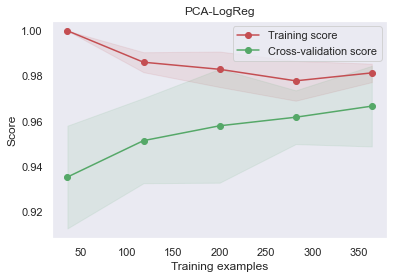

In [560]:
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_LR = INPUTS

param = {
    'LogReg__C': np.arange(1,11),
    'pca__n_components':np.arange(7,14) # Lets see which numbe of PCA it chooses having in mind that 7 and 10 at most seemed the most reasonable
}

pipe = Pipeline(steps=[('scaler',StandardScaler()),
                       ('pca', PCA(svd_solver='full', random_state=42)), # Preprocess the variables when training the model 
                       ('LogReg',LogisticRegression(random_state=42))]) # Model to use in the pipeline

model_fit, y_pred_tr, y_prob_tr, y_pred_ts, y_prob_ts = model_selection(param, pipe, 'f1', 'PCA-LogReg', learning=True)
LogReg_fit = model_fit

<Figure size 1080x864 with 0 Axes>

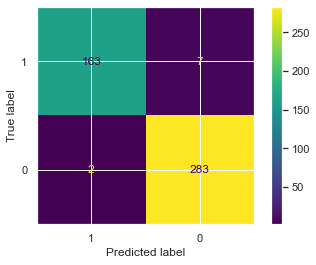

Accuracy: 0.980220
Precision: 0.987879
Recall: 0.958824
Balanced Accuracy: 0.975903
F1 Score: 0.973134


<Figure size 1080x864 with 0 Axes>

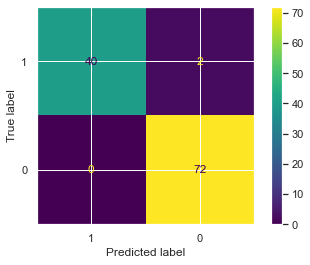

Accuracy: 0.982456
Precision: 1.000000
Recall: 0.952381
Balanced Accuracy: 0.976190
F1 Score: 0.975610


In [561]:
lr_train_metrics = display_metrics(y_train, y_pred_tr, 1, 0, 'LogReg')
lr_test_metrics = display_metrics(y_test, y_pred_ts, 1, 0, 'LogReg')

In [409]:
# Obtain Cross-Validation score
print("Training F1 score is:", cross_val_score(model_fit, X_train, y_train, cv=5, scoring='f1').mean())
print("Training recall is:", cross_val_score(model_fit, X_train, y_train, cv=5, scoring='recall').mean())
print("Training precision is:", cross_val_score(model_fit, X_train, y_train, cv=5, scoring='precision').mean())

Training F1 score is: 0.9667008847166881
Training recall is: 0.9470588235294117
Training precision is: 0.9880570409982175


In [395]:
results = pd.DataFrame(data=lr_test_metrics).set_index('model')
all_results.drop(['LogReg'], inplace=True, errors='ignore')
all_results = pd.concat([all_results, results])
all_results

acc   prec    recall   bal_acc       f1
model                                                 
baseline  0.964912  0.975  0.928571  0.957341  0.95122
LogReg    0.982456  1.000  0.952381  0.976190  0.97561

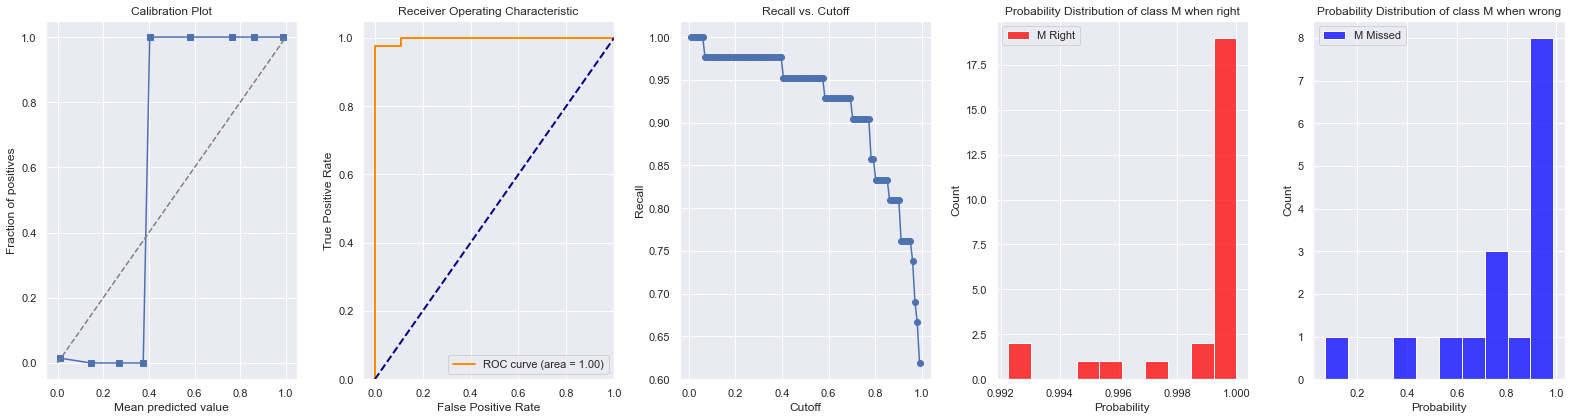

In [396]:
metricsPlots(y_test, y_pred_ts, y_prob_ts)

### Decision Tree

PCA-DT Trained
Best params:
 {'DT__criterion': 'entropy', 'DT__max_depth': 7, 'pca__n_components': 11}


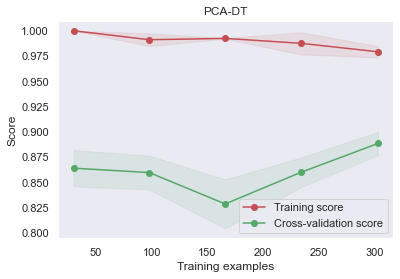

In [ ]:
param = {
    'pca__n_components': np.arange(7,15), # Again we obtain ~10 as result makes sense
    'DT__max_depth': np.arange(1, 30, 3),
    'DT__criterion': ['entropy', 'gini'],
}

pipe = Pipeline(steps=[('scaler',StandardScaler()),
                       ('pca', PCA()),
                       ('DT', DecisionTreeClassifier(random_state=42))]) 
                                                     
model_fit, y_pred_tr, y_prob_tr, y_pred_ts, y_prob_ts = model_selection(param, pipe, 'f1', 'PCA-DT', cv=3, learning=True)

In [ ]:
model_fit.best_estimator_['DT'].get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 7,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

<Figure size 1080x864 with 0 Axes>

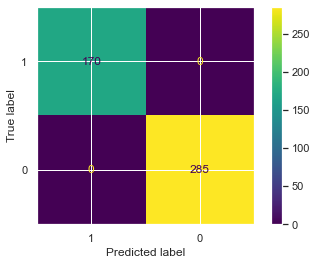

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
Balanced Accuracy: 1.000000
F1 Score: 1.000000


<Figure size 1080x864 with 0 Axes>

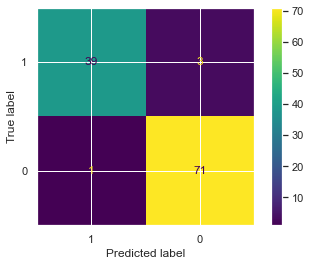

Accuracy: 0.964912
Precision: 0.975000
Recall: 0.928571
Balanced Accuracy: 0.957341
F1 Score: 0.951220


In [ ]:
lr_train_metrics = display_metrics(y_train, y_pred_tr, 1, 0, 'DecisionTree')
lr_test_metrics = display_metrics(y_test, y_pred_ts, 1, 0, 'DecisionTree')

In [ ]:
# Obtain Cross-Validation score
print("Training F1 score is:", cross_val_score(LogReg_fit, X_train, y_train, cv=5, scoring='f1').mean())
print("Training recall is:", cross_val_score(LogReg_fit, X_train, y_train, cv=5, scoring='recall').mean())
print("Training precision is:", cross_val_score(LogReg_fit, X_train, y_train, cv=5, scoring='precision').mean())

Training F1 score is: 0.96963503289879
Training recall is: 0.9588235294117646
Training precision is: 0.9830065359477125


In [ ]:
results = pd.DataFrame(data=lr_test_metrics).set_index('model')
all_results.drop(['DTree'], inplace=True, errors='ignore')
all_results = pd.concat([all_results, results])
all_results

acc      prec    recall   bal_acc        f1
model                                                         
baseline      0.964912  0.975000  0.928571  0.957341  0.951220
LogReg        0.982456  1.000000  0.952381  0.976190  0.975610
RandomForest  0.956140  0.974359  0.904762  0.945437  0.938272
XGBoost       0.964912  0.975000  0.928571  0.957341  0.951220
DecisionTree  0.964912  0.975000  0.928571  0.957341  0.951220

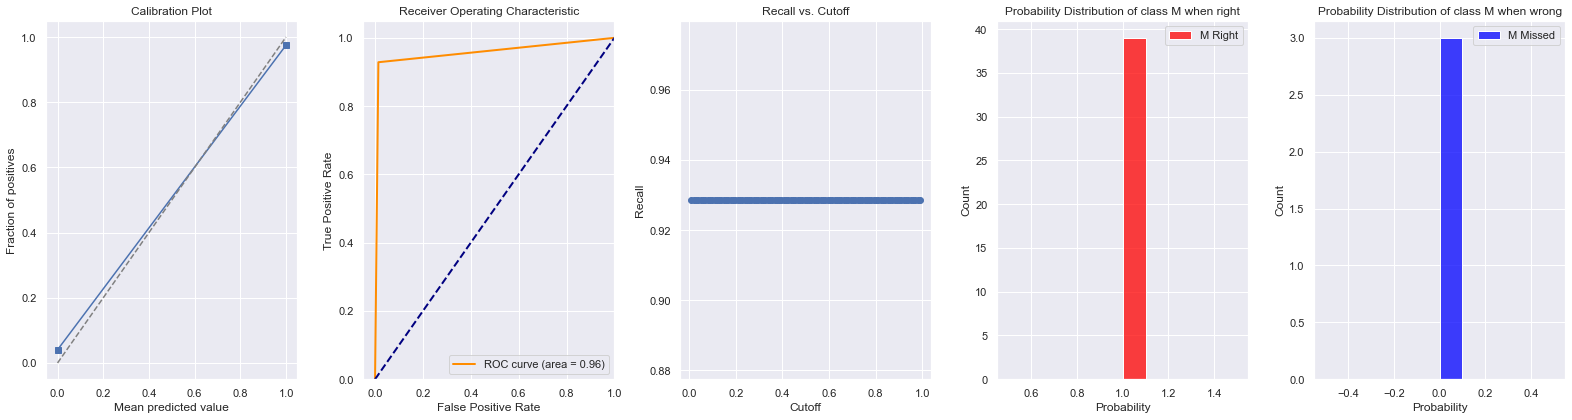

In [ ]:
metricsPlots(y_test, y_pred_ts, y_prob_ts)

### Random Forest 

PCA-RandomForest Trained
Best params:
 {'RF__max_depth': 5, 'RF__n_estimators': 50, 'pca__n_components': 9}


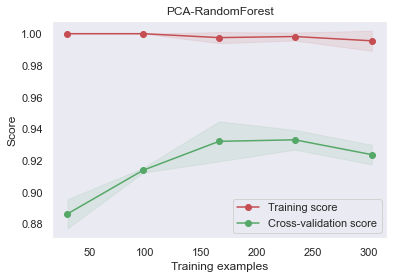

In [481]:
param = {
    'pca__n_components': np.arange(7,15), # Again we obtain 10 as result makes sense
    'RF__n_estimators': np.arange(50, 100, 10),
    'RF__max_depth': np.arange(5,10) 
}

pipe = Pipeline(steps=[('scaler',StandardScaler()),
                       ('pca', PCA()),
                       ('RF', RandomForestClassifier(random_state=42,
                                                     criterion='entropy',
                                                     bootstrap='true'))]) 

model_fit, y_pred_tr, y_prob_tr, y_pred_ts, y_prob_ts = model_selection(param, pipe, 'f1', 'PCA-RandomForest', cv=3, learning=True)

In [482]:
model_fit.best_estimator_['RF'].get_params()

{'bootstrap': 'true',
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 5,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

<Figure size 1080x864 with 0 Axes>

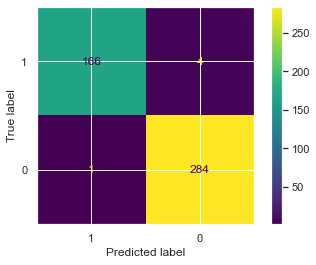

Accuracy: 0.989011
Precision: 0.994012
Recall: 0.976471
Balanced Accuracy: 0.986481
F1 Score: 0.985163


<Figure size 1080x864 with 0 Axes>

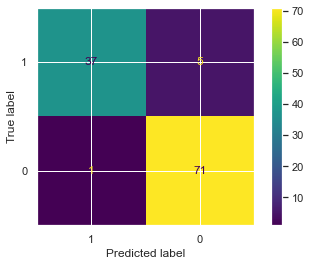

Accuracy: 0.947368
Precision: 0.973684
Recall: 0.880952
Balanced Accuracy: 0.933532
F1 Score: 0.925000


In [483]:
lr_train_metrics = display_metrics(y_train, y_pred_tr, 1, 0, 'RandomForest')
lr_test_metrics = display_metrics(y_test, y_pred_ts, 1, 0, 'RandomForest')

In [1]:
# Obtain Cross-Validation score
# print("Training F1 score is:", cross_val_score(model_fit, X_train, y_train, cv=5, scoring='f1').mean())
# print("Training recall is:", cross_val_score(model_fit, X_train, y_train, cv=5, scoring='recall').mean())
# print("Training precision is:", cross_val_score(model_fit, X_train, y_train, cv=5, scoring='precision').mean())

In [435]:
results = pd.DataFrame(data=lr_test_metrics).set_index('model')
all_results.drop(['RandomForest'], inplace=True, errors='ignore')
all_results = pd.concat([all_results, results])
all_results

acc      prec    recall   bal_acc        f1
model                                                         
baseline      0.964912  0.975000  0.928571  0.957341  0.951220
LogReg        0.982456  1.000000  0.952381  0.976190  0.975610
RandomForest  0.956140  0.974359  0.904762  0.945437  0.938272

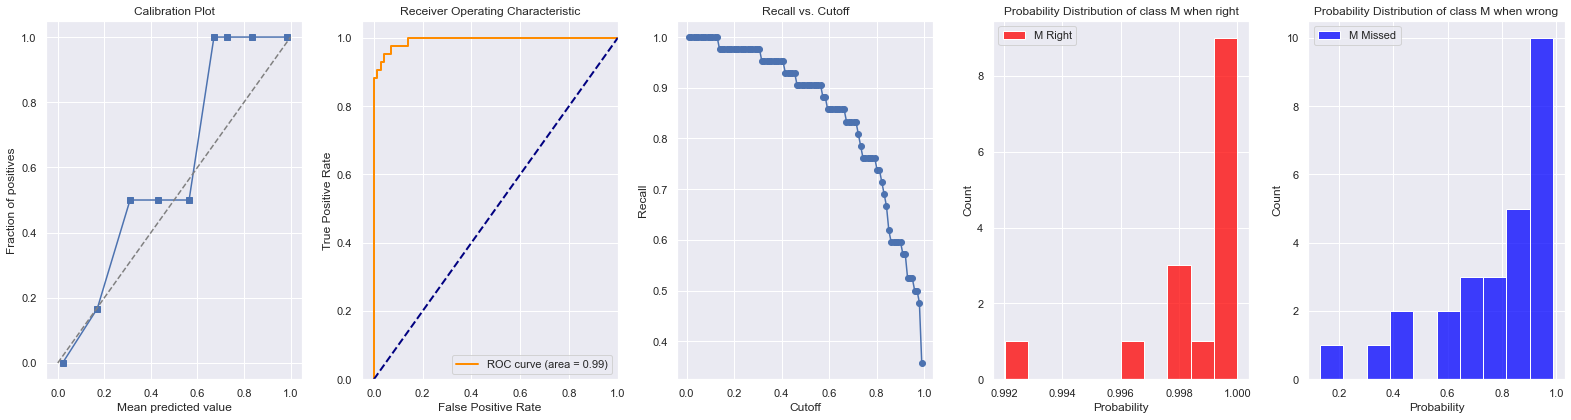

In [422]:
metricsPlots(y_test, y_pred_ts, y_prob_ts)

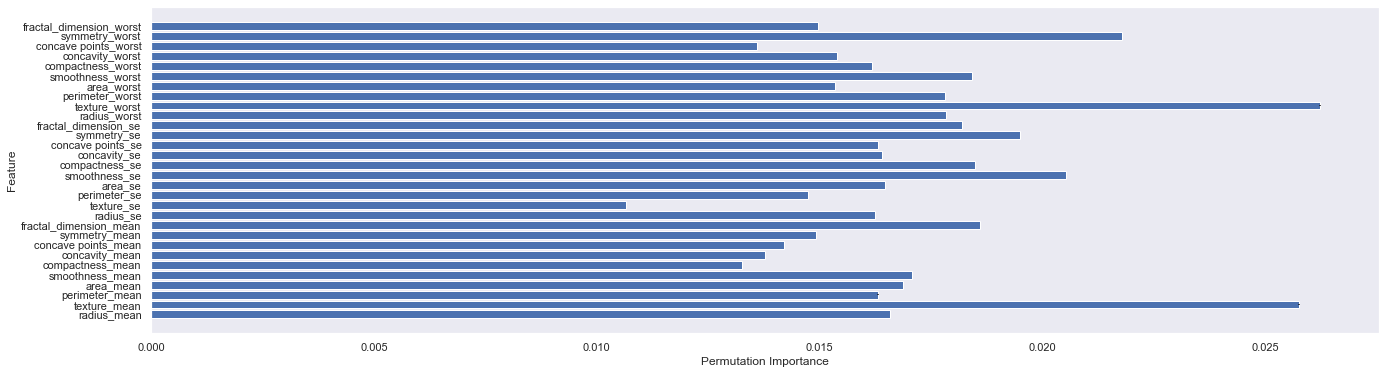

In [34]:
# Looking at features importance doesnt give much information since we have applied PCA so the graph is a bit misleading
importances_rf = permutation_importance(model_fit, 
                                        X_train, y_train,
                                        n_repeats=10,
                                        random_state=42)

fig = plt.figure(2, figsize=(22, 6)) 
plt.barh(INPUTS, importances_rf.importances_mean, yerr=importances_rf.importances_std)
plt.ylabel('Feature')
plt.xlabel('Permutation Importance')
plt.grid()
plt.show()

#### Random Forest [No PCA]

In [35]:
param = {
    'RF__n_estimators': np.arange(50, 100, 10),
    'RF__max_depth': np.arange(5,10) 
}

pipe = Pipeline(steps=[('scaler',StandardScaler()),
                       ('RF', RandomForestClassifier(random_state=42,
                                                     criterion='entropy',
                                                     bootstrap='true'))]) 

model_fit, y_pred_tr, y_prob_tr, y_pred_ts, y_prob_ts = model_selection(param, pipe, 'f1', 'RandomForest', cv=3, learning=False)

RandomForest Trained
Best params:
 {'RF__max_depth': 7, 'RF__n_estimators': 80}


<Figure size 1080x864 with 0 Axes>

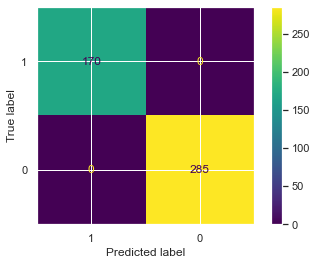

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
Balanced Accuracy: 1.000000
F1 Score: 1.000000


<Figure size 1080x864 with 0 Axes>

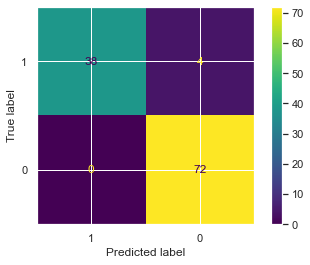

Accuracy: 0.964912
Precision: 1.000000
Recall: 0.904762
Balanced Accuracy: 0.952381
F1 Score: 0.950000


In [549]:
lr_train_metrics = display_metrics(y_train, y_pred_tr, 1, 0, 'RandomForest')
lr_test_metrics = display_metrics(y_test, y_pred_ts, 1, 0, 'RandomForest')

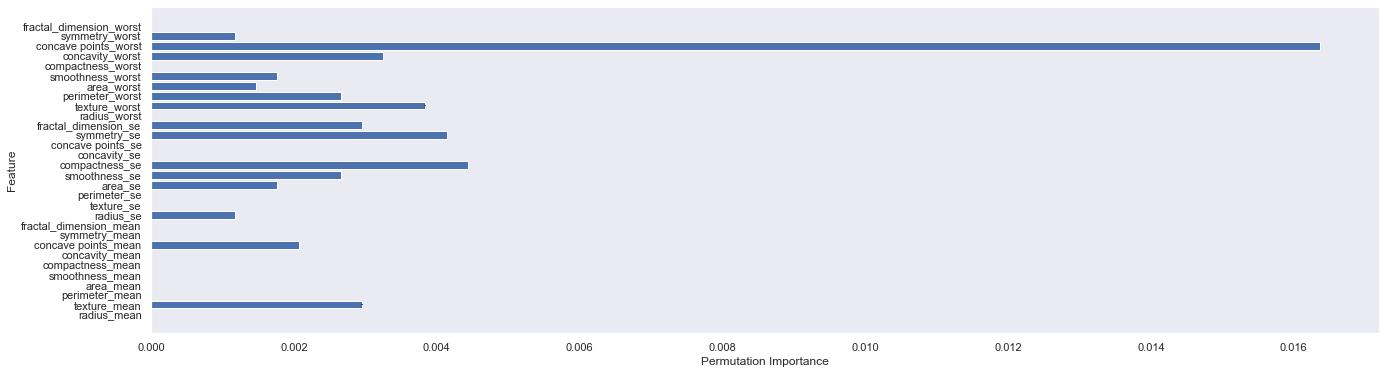

In [36]:
# Random Forest gives high importance to: concativity_points_worst
importances_rf = permutation_importance(model_fit, 
                                        X_train, y_train,
                                        n_repeats=10,
                                        random_state=42)

fig = plt.figure(2, figsize=(22, 6)) 
plt.barh(INPUTS, importances_rf.importances_mean, yerr=importances_rf.importances_std)
plt.ylabel('Feature')
plt.xlabel('Permutation Importance')
plt.grid()
plt.show()

In [557]:
dict(zip(df.columns.tolist(), importances_rf.importances_mean))

{'diagnosis': 0.0,
 'radius_mean': 0.002955088931943961,
 'texture_mean': 0.0,
 'perimeter_mean': 0.0,
 'area_mean': 0.0,
 'smoothness_mean': 0.0,
 'compactness_mean': 0.0,
 'concavity_mean': 0.002064896755162271,
 'concave points_mean': 0.0,
 'symmetry_mean': 0.0,
 'fractal_dimension_mean': 0.0011799410029498692,
 'radius_se': 0.0,
 'texture_se': 0.0,
 'perimeter_se': 0.0017699115044248037,
 'area_se': 0.0026548672566372054,
 'smoothness_se': 0.004433506135344156,
 'compactness_se': 0.0,
 'concavity_se': 0.0,
 'concave points_se': 0.004140266359463118,
 'symmetry_se': 0.002949852507374673,
 'fractal_dimension_se': 0.0,
 'radius_worst': 0.003840044684156363,
 'texture_worst': 0.0026601036812064936,
 'perimeter_worst': 0.0014714609275573887,
 'area_worst': 0.0017699115044248037,
 'smoothness_worst': 0.0,
 'compactness_worst': 0.0032500741826814285,
 'concavity_worst': 0.016370062199568512,
 'concave points_worst': 0.0011799410029498692,
 'symmetry_worst': 0.0}

### XGBoost

PCA-XGBoost Trained
Best params:
 {'pca__n_components': 10, 'xgb__learning_rate': 0.30000000000000004, 'xgb__n_estimators': 70}


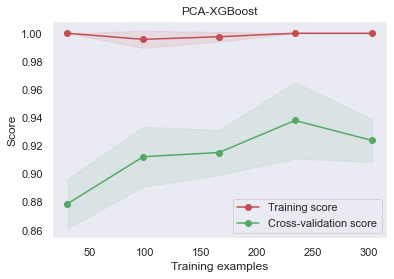

In [476]:
param = {
    'pca__n_components': np.arange(7,15), 
    'xgb__n_estimators': np.arange(50,100,10),  
    'xgb__learning_rate': np.arange(0.1,0.31,0.05),  # Con 0.4 me ha salido 0.951220 como antes
}

pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
]) 

model_fit, y_pred_tr, y_prob_tr, y_pred_ts, y_prob_ts = model_selection(param, pipe, 'f1', 'PCA-XGBoost', cv=3, learning=True)

<Figure size 1080x864 with 0 Axes>

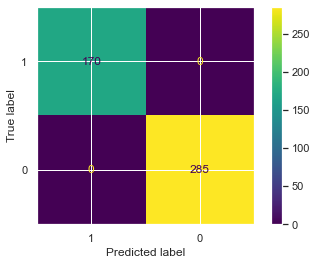

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
Balanced Accuracy: 1.000000
F1 Score: 1.000000


<Figure size 1080x864 with 0 Axes>

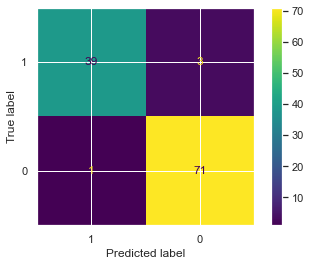

Accuracy: 0.964912
Precision: 0.975000
Recall: 0.928571
Balanced Accuracy: 0.957341
F1 Score: 0.951220


In [453]:
lr_train_metrics = display_metrics(y_train, y_pred_tr, 1, 0, 'XGBoost')
lr_test_metrics = display_metrics(y_test, y_pred_ts, 1, 0, 'XGBoost')

In [37]:
# Obtain Cross-Validation score
# print("Training F1 score is:", cross_val_score(model_fit, X_train, y_train, cv=5, scoring='f1').mean())
# print("Training recall is:", cross_val_score(model_fit, X_train, y_train, cv=5, scoring='recall').mean())
# print("Training precision is:", cross_val_score(model_fit, X_train, y_train, cv=5, scoring='precision').mean())

In [454]:
results = pd.DataFrame(data=lr_test_metrics).set_index('model')
all_results.drop(['XGBoost'], inplace=True, errors='ignore')
all_results = pd.concat([all_results, results])
all_results

acc      prec    recall   bal_acc        f1
model                                                         
baseline      0.964912  0.975000  0.928571  0.957341  0.951220
LogReg        0.982456  1.000000  0.952381  0.976190  0.975610
RandomForest  0.956140  0.974359  0.904762  0.945437  0.938272
XGBoost       0.964912  0.975000  0.928571  0.957341  0.951220

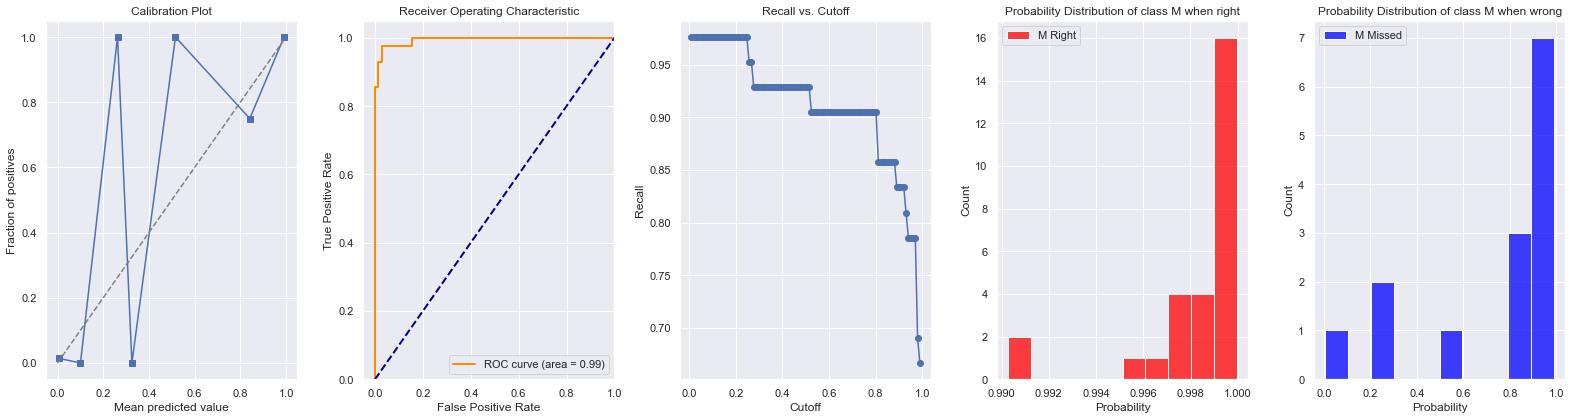

In [455]:
metricsPlots(y_test, y_pred_ts, y_prob_ts)

### MLP

MLP Trained
Best params:
 {'MLP__alpha': 0.2, 'MLP__hidden_layer_sizes': (10,)}


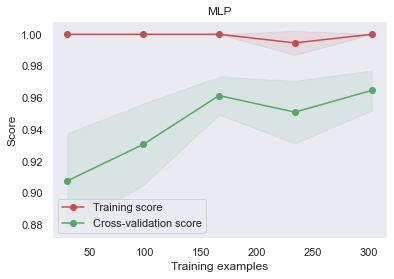

In [544]:
param = {
         #'pca__n_components': np.arange(7,15), # Le pasamos el dato raw a la red y dejamos que sea ella quien saque sus propias conclusiones
         'MLP__alpha': [0.01, 0.1, 0.2, 0.25, 0.3], # L2 regularization term 
         'MLP__hidden_layer_sizes':[(5,),(10,),(15,),(5,5,), (10,10,)]} # Number of neurons in each hidden layer, enters as tuples
         

pipe = Pipeline(steps=[('scaler', StandardScaler()),
                       #('pca', PCA()),
                       ('MLP', MLPClassifier(solver='lbfgs', # Update function
                                             activation='logistic', # Logistic sigmoid activation function
                                             max_iter=450, # Maximum number of iterations
                                             tol=1e-4, # Tolerance for the optimization
                                             random_state=42))]) # For replication

model_fit, y_pred_tr, y_prob_tr, y_pred_ts, y_prob_ts = model_selection(param, pipe, 'f1', 'MLP', cv=3, learning=True)                                             

<Figure size 1080x864 with 0 Axes>

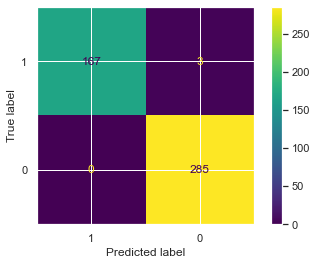

Accuracy: 0.993407
Precision: 1.000000
Recall: 0.982353
Balanced Accuracy: 0.991176
F1 Score: 0.991098


<Figure size 1080x864 with 0 Axes>

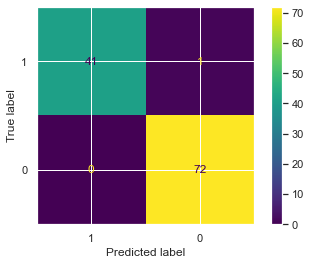

Accuracy: 0.991228
Precision: 1.000000
Recall: 0.976190
Balanced Accuracy: 0.988095
F1 Score: 0.987952


In [545]:
lr_train_metrics = display_metrics(y_train, y_pred_tr, 1, 0, 'MLP')
lr_test_metrics = display_metrics(y_test, y_pred_ts, 1, 0, 'MLP')

In [546]:
results = pd.DataFrame(data=lr_test_metrics).set_index('model')
all_results.drop(['MLP'], inplace=True, errors='ignore')
all_results = pd.concat([all_results, results])
all_results

acc      prec    recall   bal_acc        f1
model                                                         
baseline      0.964912  0.975000  0.928571  0.957341  0.951220
LogReg        0.982456  1.000000  0.952381  0.976190  0.975610
RandomForest  0.956140  0.974359  0.904762  0.945437  0.938272
XGBoost       0.964912  0.975000  0.928571  0.957341  0.951220
DecisionTree  0.964912  0.975000  0.928571  0.957341  0.951220
PCA-MLP       0.973684  1.000000  0.928571  0.964286  0.962963
MLP           0.991228  1.000000  0.976190  0.988095  0.987952

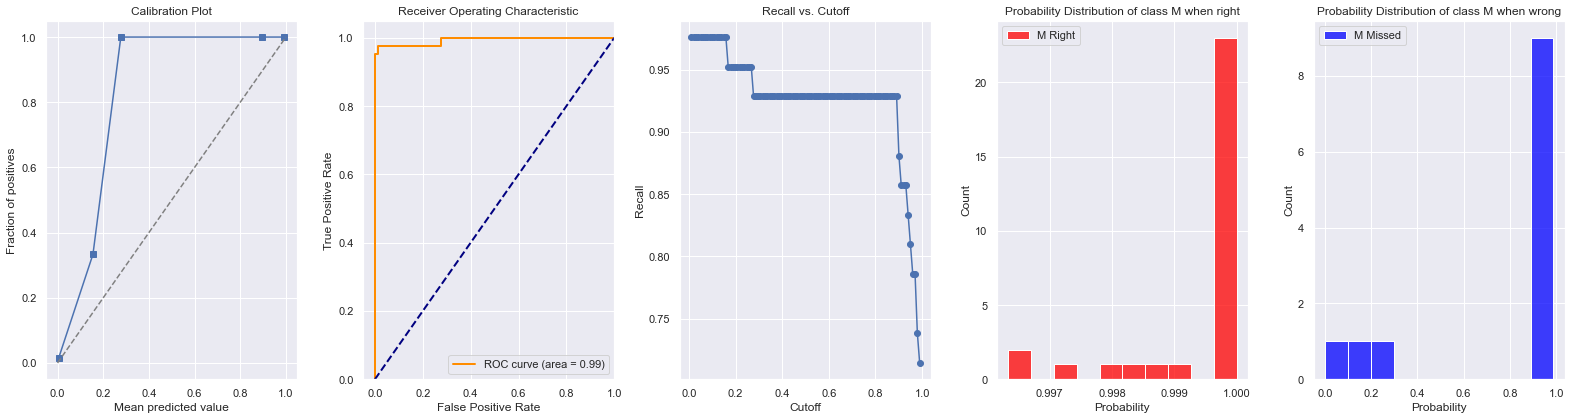

In [488]:
metricsPlots(y_test, y_pred_ts, y_prob_ts)

In [516]:
mlp = model_fit.best_estimator_['MLP']
wts = mlp.coefs_
bias = mlp.intercepts_
actfunc = ['identity', model_fit.best_estimator_['MLP'].get_params()['activation'], mlp.out_activation_]

X = model_fit.best_estimator_['scaler'].transform(X_train)
X = pd.DataFrame(X, columns=X_train.columns)
y = pd.DataFrame(y_train, columns=X_train.columns)

sens_end_layer = 'last'
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True
sensmlp = ns.jacobian_mlp(wts, bias, actfunc, X, y, use_torch=False)

In [523]:
# According to the MLP the most important feature in detecting the if the cell is malignant is the texture_worst
sensmlp.summary()

Sensitivity analysis of [30, 10, 1] MLP network.

Sensitivity measures of each output:

$radius_mean 

                             mean       std  mean_squared
radius_mean              0.000175  0.005608      0.005610
texture_mean             0.000949  0.006737      0.006804
perimeter_mean           0.001747  0.008803      0.008975
area_mean                0.002979  0.011814      0.012184
smoothness_mean          0.004339  0.017034      0.017578
compactness_mean        -0.013913  0.046764      0.048790
concavity_mean           0.019312  0.065840      0.068614
concave points_mean      0.015425  0.051815      0.054062
symmetry_mean            0.000883  0.006957      0.007013
fractal_dimension_mean   0.004646  0.017000      0.017623
radius_se                0.024545  0.080944      0.084584
texture_se              -0.014578  0.055855      0.057726
perimeter_se             0.013379  0.043844      0.045839
area_se                  0.022510  0.075302      0.078594
smoothness_se            0.

d:\ProgramFiles\anaconda3\envs\ml\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 1080x864 with 0 Axes>

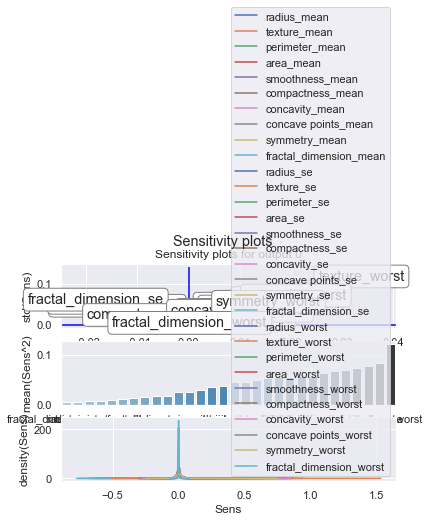

In [525]:
plt.figure(figsize=(15,12))
sensmlp.plot()
plt.show()

### MLP-PCA

PCA-MLP Trained
Best params:
 {'MLP__alpha': 0.2, 'MLP__hidden_layer_sizes': (10,), 'pca__n_components': 10}


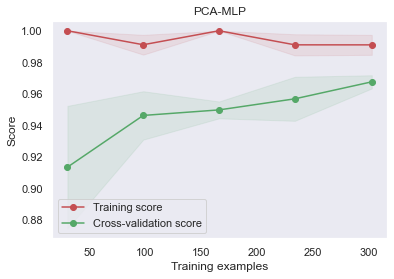

In [530]:
param = {
         'pca__n_components': np.arange(7,15), # De nuevo el resultado ~10 
         'MLP__alpha': [0.01, 0.1, 0.2, 0.25, 0.3], # L2 regularization term 
         'MLP__hidden_layer_sizes':[(5,),(10,),(15,),(5,5,), (10,10,)]} # Number of neurons in each hidden layer, enters as tuples
         

pipe = Pipeline(steps=[('scaler', StandardScaler()),
                       ('pca', PCA()),
                       ('MLP', MLPClassifier(solver='lbfgs', # Update function
                                             activation='logistic', # Logistic sigmoid activation function
                                             max_iter=450, # Maximum number of iterations
                                             tol=1e-4, # Tolerance for the optimization
                                             random_state=42))]) # For replication

model_fit, y_pred_tr, y_prob_tr, y_pred_ts, y_prob_ts = model_selection(param, pipe, 'f1', 'PCA-MLP', cv=3, learning=True)                                             

<Figure size 1080x864 with 0 Axes>

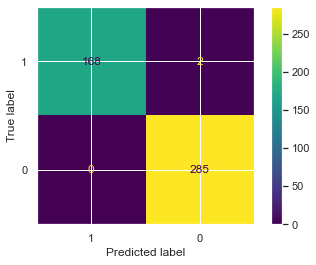

Accuracy: 0.995604
Precision: 1.000000
Recall: 0.988235
Balanced Accuracy: 0.994118
F1 Score: 0.994083


<Figure size 1080x864 with 0 Axes>

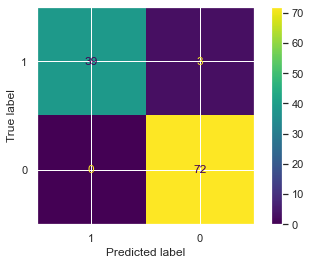

Accuracy: 0.973684
Precision: 1.000000
Recall: 0.928571
Balanced Accuracy: 0.964286
F1 Score: 0.962963


In [542]:
lr_train_metrics = display_metrics(y_train, y_pred_tr, 1, 0, 'PCA-MLP')
lr_test_metrics = display_metrics(y_test, y_pred_ts, 1, 0, 'PCA-MLP')

In [543]:
results = pd.DataFrame(data=lr_test_metrics).set_index('model')
all_results.drop(['PCA-MLP'], inplace=True, errors='ignore')
all_results = pd.concat([all_results, results])
all_results

acc      prec    recall   bal_acc        f1
model                                                         
baseline      0.964912  0.975000  0.928571  0.957341  0.951220
LogReg        0.982456  1.000000  0.952381  0.976190  0.975610
RandomForest  0.956140  0.974359  0.904762  0.945437  0.938272
XGBoost       0.964912  0.975000  0.928571  0.957341  0.951220
DecisionTree  0.964912  0.975000  0.928571  0.957341  0.951220
PCA-MLP       0.973684  1.000000  0.928571  0.964286  0.962963

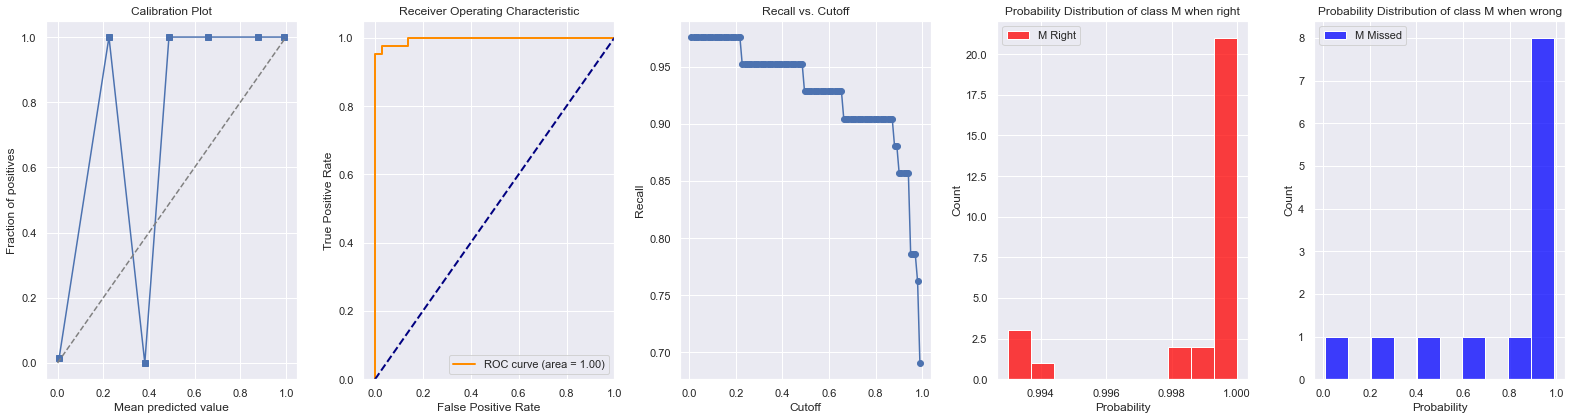

In [533]:
metricsPlots(y_test, y_pred_ts, y_prob_ts)

In [534]:
mlp = model_fit.best_estimator_['MLP']
wts = mlp.coefs_
bias = mlp.intercepts_
actfunc = ['identity', model_fit.best_estimator_['MLP'].get_params()['activation'], mlp.out_activation_]

X = model_fit.best_estimator_['pca'].transform(model_fit.best_estimator_['scaler'].transform(X_train))
X = pd.DataFrame(X, columns=[f'PC{i}' for i in range(1,11)])
y = pd.DataFrame(y_train)

sens_end_layer = 'last'
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True
sensmlp = ns.jacobian_mlp(wts, bias, actfunc, X, y, use_torch=False)

In [535]:
# No new information from the sensitivity analysis, the most important PC is the first and then descending
sensmlp.summary()

Sensitivity analysis of [10, 10, 1] MLP network.

Sensitivity measures of each output:

$diagnosis 

          mean       std  mean_squared
PC1   0.042424  0.137801      0.144184
PC2  -0.028100  0.087112      0.091532
PC3  -0.017540  0.065066      0.067388
PC4  -0.012824  0.042573      0.044462
PC5  -0.024854  0.075617      0.079597
PC6  -0.006717  0.021000      0.022048
PC7  -0.006647  0.028464      0.029230
PC8  -0.014188  0.053774      0.055614
PC9   0.026850  0.081812      0.086106
PC10  0.023981  0.072195      0.076074


In [536]:
sensmlp.info()

Sensitivity analysis of [10, 10, 1] MLP network.

455 samples

Sensitivities of each output (only 5 first samples):

$diagnosis 

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.038184 -0.023308 -0.027557 -0.011214 -0.022414 -0.001707 -0.007292   
1  0.000082 -0.000048 -0.000040 -0.000004 -0.000093 -0.000037 -0.000080   
2  0.000271 -0.000449  0.000315 -0.000206 -0.000187 -0.000245  0.000055   
3  0.005056 -0.005070 -0.008023 -0.001330 -0.008879 -0.002569 -0.009140   
4  0.000131 -0.000110 -0.000131 -0.000047 -0.000117 -0.000021 -0.000070   

        PC8       PC9      PC10  
0 -0.017115  0.021436  0.021532  
1  0.000014  0.000095  0.000100  
2  0.000004  0.000289  0.000179  
3  0.000733  0.007633  0.010279  
4 -0.000052  0.000102  0.000120  


d:\ProgramFiles\anaconda3\envs\ml\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Figure size 1080x864 with 0 Axes>

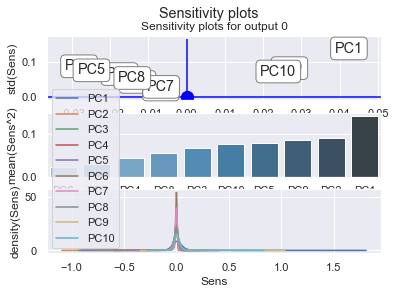

In [511]:
plt.figure(figsize=(15,12))
sensmlp.plot()
plt.show()

## Conclusions

The most promising results have been obtained by the MLP (without PCA preprocessing) and the Logistic Regression once added some fine-tuning and preprocessing. While the MLP achieves the highest F1 score with a centesimal above its contrary, I would stick with logistic regression for its simplicity and explainability which might come in handy if required to provide explanation to professionals not specialized in this field, however, again if we were to just go for results, MLP would then be the choice. RF found concativity_points_worst to be the most important variable in the detection

<b>Model of Choice:</b> Logistic Regression

In [547]:
# Sort all values of a df based on their column f1

all_results.sort_values(by='f1', ascending=False)

acc      prec    recall   bal_acc        f1
model                                                         
MLP           0.991228  1.000000  0.976190  0.988095  0.987952
LogReg        0.982456  1.000000  0.952381  0.976190  0.975610
PCA-MLP       0.973684  1.000000  0.928571  0.964286  0.962963
baseline      0.964912  0.975000  0.928571  0.957341  0.951220
XGBoost       0.964912  0.975000  0.928571  0.957341  0.951220
DecisionTree  0.964912  0.975000  0.928571  0.957341  0.951220
RandomForest  0.956140  0.974359  0.904762  0.945437  0.938272

In [ ]:
# Sort all values of a df based on their column f1
df.sort_values(by='f1', ascending=False)<jupyter_output><empty_output><jupyter_text>**Question 2:** How many unique values are there

## Deployment

In [564]:
model_path = os.path.join(os.getcwd(), '../devops/LogReg_fit.joblib')
dump(LogReg_fit, model_path) 

['d:\\Universidad\\MasterBD\\capg\\notebooks\\../devops/LogReg_fit.joblib']